## Compute my own drag coefficient from SAR data

To get the average Cd on a disk, wee need to compute the expression with integrals. Use cd_mean3 for new_dsg. For K25, the disk-average Cd is simply Cd0.

I computed a K based on V (cf Foster 2009), but this doesn't really change my distribution of C_K25 compared to when I just use the average K = 50 used for the fitting.

NB: Unfortunately, when I use a reasonable scaling for K as a function of v, and inject it to compute C from C / sqrt(K), I get the correct dependance of Cd on Vmax, but a dependance of Cd on Rmax that is inversely that observed when considering Cd r v2 = cst. I think the filtering will not change anything. Note that using Cd r v2 = cst for the lower B values (i.e larger Rmax) will lead to higher Cd values in the inner-core, but is that really true?

NB: Yet, when I use my C from Cd r v2 = cst to compute K from C / sqrt(K), I obtain a K that seems to scale with vmx^2. This is actually nice! How does it compare to the KPP scheme (Is this scheme the best one in Foster) and the measurements performed by Jun A Zhang and Zhao et al 2019 (BLM)? Do the same as for my Cd: use an arbitrary function of K as a function of v, and then integrate to estimate a constant K. My fitted model needs to be consistent with that. From the literature K increases (either linearly or quadratically) with v up to 40 m/s, and then keeps increasing or saturates (depending on the reference). K is rarely above 100 m2/s, and usually around 20-50.

Assumption: See Foster 2009: KPP model with h(r). K(z) is maximal (Km) at z = h/3, we thus assume that the average value of K over z is (h * Km)/3 / h, considering that h is the boundary layer height, and thus is Km / 3. For the radial dependance, we have Km ~ Ksfc ~ h(Rmax) ~ Vm^2. So the average K should really scale with Vm^2. So do not check that further.

When I estimate K either using my own Cd or a constant one, a few values exceed 1500 m2/s, but most of them are below 1500 m2/s. It's still one order of magnitude too high, but I don't want to remove these cases as they correspond to situations when the fit is really good.

Can I estimate (C /sqrt(K), c1, c2) from (Ut, VWS, Holland params)? Do I need to impose constraints on c1 or c2 first (e.g impose c2 > 0 during the fit)?

TODO: The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

TODO: When I compare my own K estimates from K01_wINFLOW_ANGLE to the KPP estimates, I find that the KPP estimates are 2.5 to 3 times bigger than my own estimates. Maybe adjust h in my KPP formula to adjust this bias. 

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_GET_OWN_C/',
}

PRMS = {
    'sav_fgs': False,
}

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [3]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

640


In [4]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

### 1) Compute Cd from all SAR data

In [5]:
### Hyperparameters
rs = np.linspace(1000, 5e5, 500)

In [6]:
# Prepare new_dsg
listOfDatasets  = []

for t in tqdm(range(len(dsg_filtered.time))):
    # Open
    ds  = dsg_filtered.isel(time=t)

    # Determined parameters
    vmx = float(ds.vmx_hol)
    rmx = float(ds.rmx_hol)
    vmn = float(ds.vmn_hol)
    B   = float(ds.B_hol)
    lat = float(ds.lat)
    fcr = abs(float(ds.fcor))
    Ut  = float(ds.speed)
    
    # Holland
    V    = holland_profile(rs, lat, B, vmn, rmx, vmx)

    # Get own Cd
    cd             = np.ones_like(V) * 1e-3 # Custom
    cd_lp          = np.ones_like(V) * 1e-3 # Large and Pond

    try:
        ### Custom
        # For r > R+
        cd[V <= 10.92] = 1.2e-3 # We use 10.92 instead of 11 to ensure continuity of Cd
        outer          = (V > 10.92) & (rs >= float(ds.rps))
        cd[outer]      = (0.49 + 0.065 * V[outer]) * 1e-3
        # For Rmax < r < R+
        cdps           = cd[rs >= float(ds.rps)][0]
        near           = (rs <= float(ds.rps)) & (rs >= float(ds.rmx))
        cd[near]       = cdps * rs[rs >= float(ds.rps)][0] * V[rs >= float(ds.rps)][0] ** 2 / (rs[near] * V[near] ** 2)

        # Average
        cd_mean1   = cd[(rs >= float(ds.rmx)) & (rs <= float(ds.r0))].mean()
        
        rmax_to_r0 = (rs >= float(ds.rmx)) & (rs <= float(ds.r0))
        # Radial integral
        cd_mean2   = np.trapz(cd[rmax_to_r0], rs[rmax_to_r0]) / float(ds.r0 - ds.rmx)
        # Cylindrical integral
        cd_mean3   = 2 * np.trapz(cd[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        ### Large and Pond formulation, averaged (cylindrical)
        # For V > 10.92 m/s
        cd_lp[V <= 10.92] = 1.2e-3 # We use 10.92 instead of 11 to ensure continuity of Cd
        low_ws            = (V > 10.92)
        cd_lp[low_ws]     = (0.49 + 0.065 * V[low_ws]) * 1e-3
        # For V > 38.62 m/s
        hgh_ws            = (V > 38.62)
        cd_lp[hgh_ws]     = 3 * 1e-3
        # Cylindrical average
        cd_mean_lp        = 2 * np.trapz(cd_lp[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        ### K
        K_mean3           = 2 * np.trapz((V[rmax_to_r0] ** 2) * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        ### K - KPP formulation, averaged (cylindrical)
        K_kpp      = (0.25 / 12) * 0.4 * 500 * (V ** 2) * np.sqrt(cd_lp) + 10 * 0.4 * V * np.sqrt(cd_lp)
        K_mean_kpp = 2 * np.trapezoid(K_kpp[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        if PRMS['sav_fgs']:
            plt.plot(rs / 1000, cd * 1e3)
            plt.axvline(ds.rmx / 1000, c='k', linewidth=3)
            plt.axvline(ds.rps / 1000, c='k')
            plt.axvline(ds.r0  / 1000, c='k', linestyle='dashed')
            plt.xlim(0, 250)
            plt.xlabel(r'Distance from TC center (km)')
            plt.ylabel('Average Cd (x1e-3)')
            plt.grid()
    
            # Save
            plt.savefig(PTHS['sav_dir'] + 'figs/{}.png'.format(ds.file_tcva.item()[:-17]), bbox_inches='tight', format='png');plt.clf()
        
    except IndexError:
        cd_mean1 = cd_mean2 = cd_mean3 = cd_mean_lp = K_mean_kpp = np.nan
    
    # Append
    ds['cd_mean1']   = cd_mean1
    ds['cd_mean2']   = cd_mean2
    ds['cd_mean3']   = cd_mean3
    ds['cd_mean_lp'] = cd_mean_lp
    ds['K_mean3']    = K_mean3
    ds['K_mean_kpp'] = K_mean_kpp
    listOfDatasets.append(ds)

# Concatenate
print('Concatenating all datasets into ds_glob. Can take a few seconds...')
new_dsg = xr.concat(listOfDatasets, dim='time') # Concatenate all datasets into a global dataset
print('Concatenation ended.')

  0%|          | 0/640 [00:00<?, ?it/s]

/tmp/ipykernel_52516/347969408.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cd_mean2   = np.trapz(cd[rmax_to_r0], rs[rmax_to_r0]) / float(ds.r0 - ds.rmx)
/tmp/ipykernel_52516/347969408.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cd_mean3   = 2 * np.trapz(cd[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)
/tmp/ipykernel_52516/347969408.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cd_mean_lp        = 2 * np.trapz(cd_lp[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)
/tmp/ipykernel_52516/347969408.py:56: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`

Concatenating all datasets into ds_glob. Can take a few seconds...
Concatenation ended.


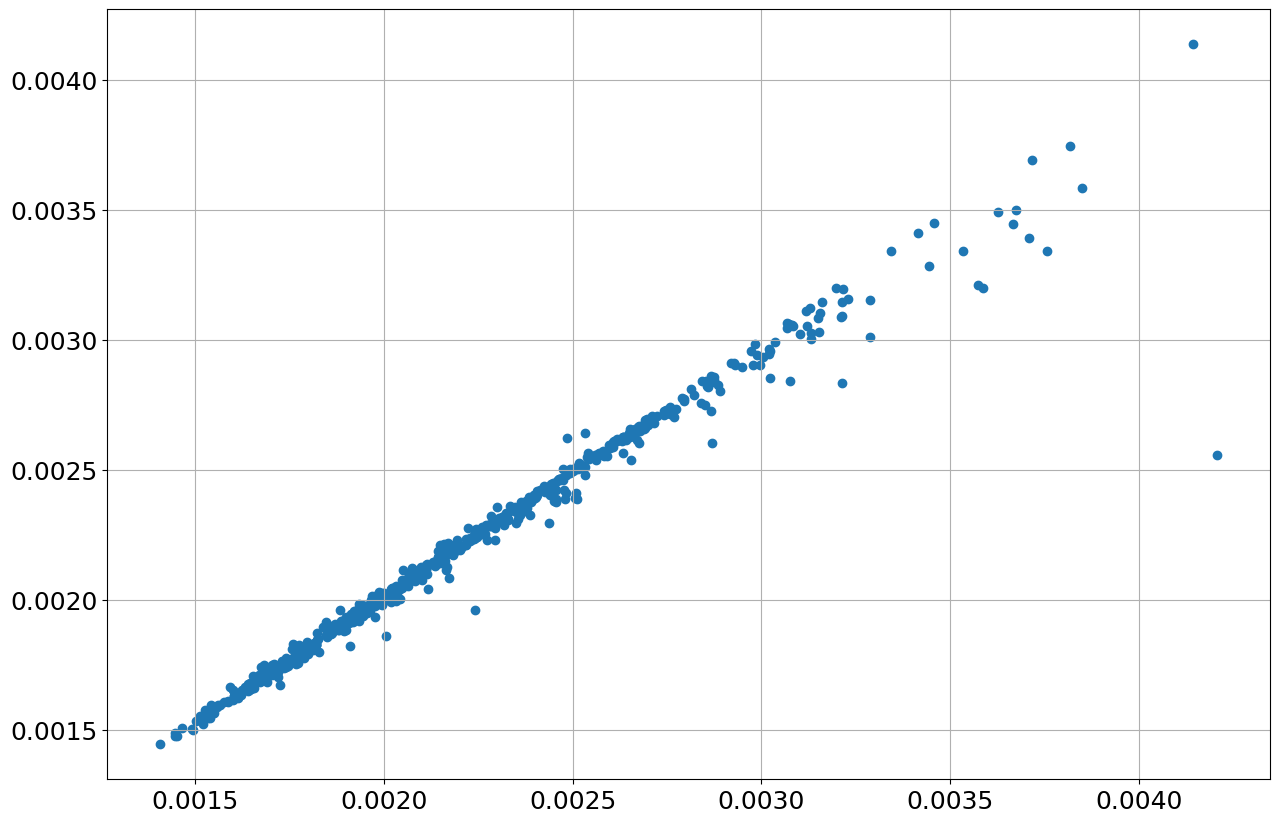

In [7]:
# Consistency between Large and Pond formulation and Cd r v2 = cst
plt.scatter(new_dsg.cd_mean3, new_dsg.cd_mean_lp)
plt.grid()

Text(0, 0.5, 'Average Cd (x1e-3)')

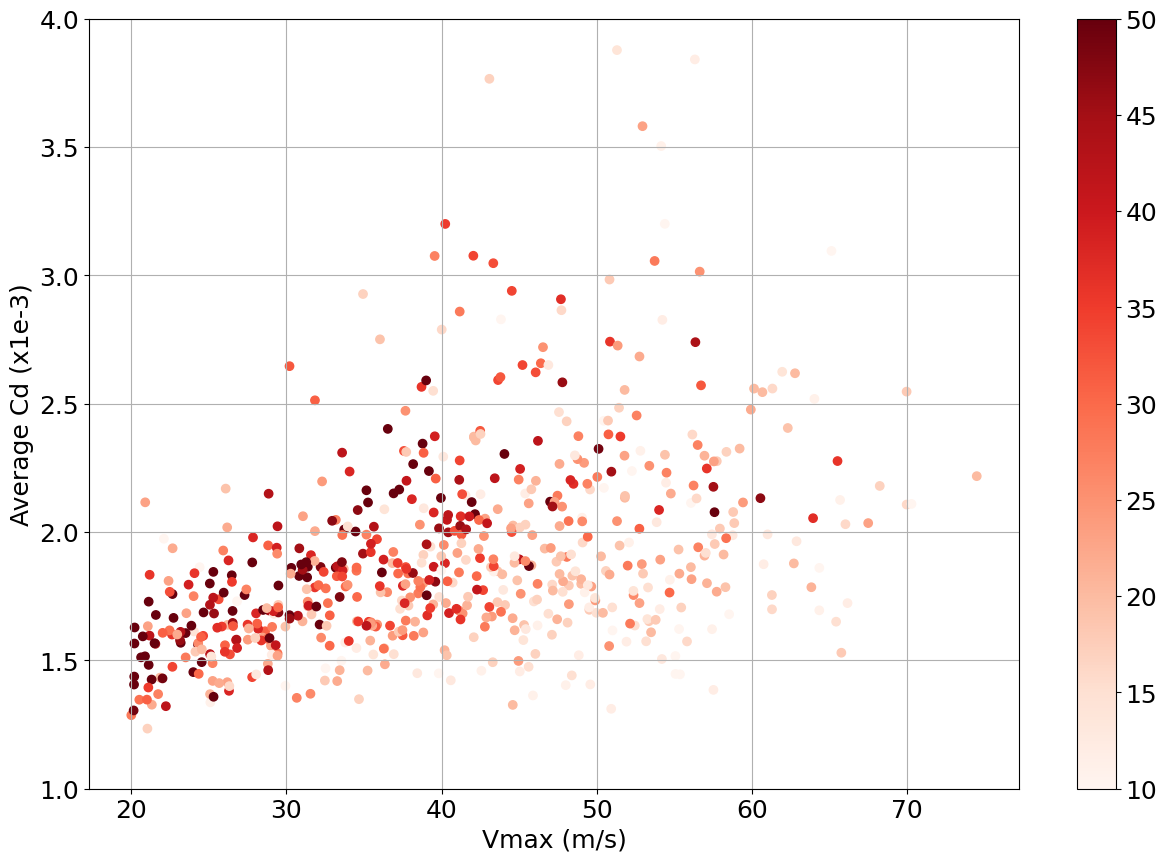

In [8]:
plt.scatter(new_dsg.vmx, new_dsg.cd_mean1 * 1e3, c=new_dsg.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
plt.ylim(1, 4)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

In [9]:
# plt.scatter(new_dsg.cd_mean1, new_dsg.cd_mean2)
# plt.grid()
# plt.plot([0.001, 0.006], [0.001, 0.006])

Text(0, 0.5, 'Average Cd (x1e-3)')

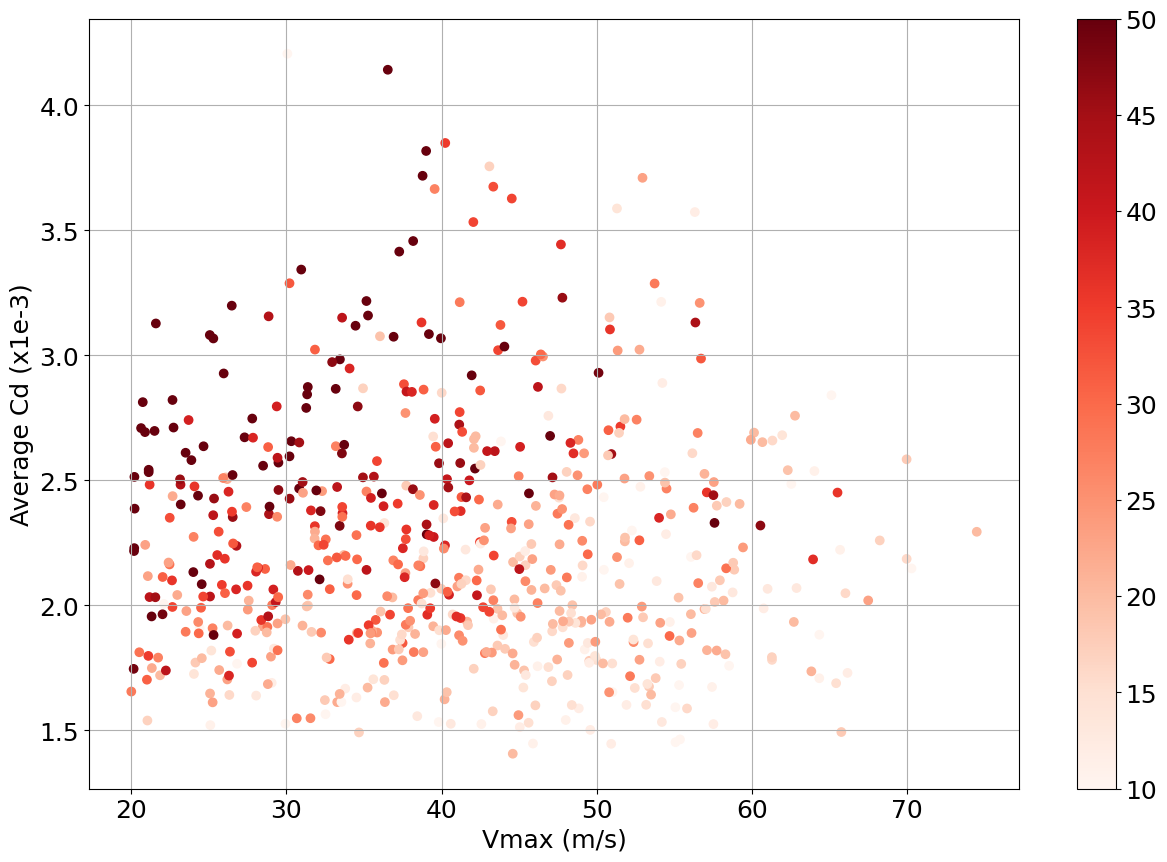

In [10]:
plt.scatter(new_dsg.vmx, new_dsg.cd_mean3 * 1e3, c=new_dsg.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
# plt.ylim(1, 4)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

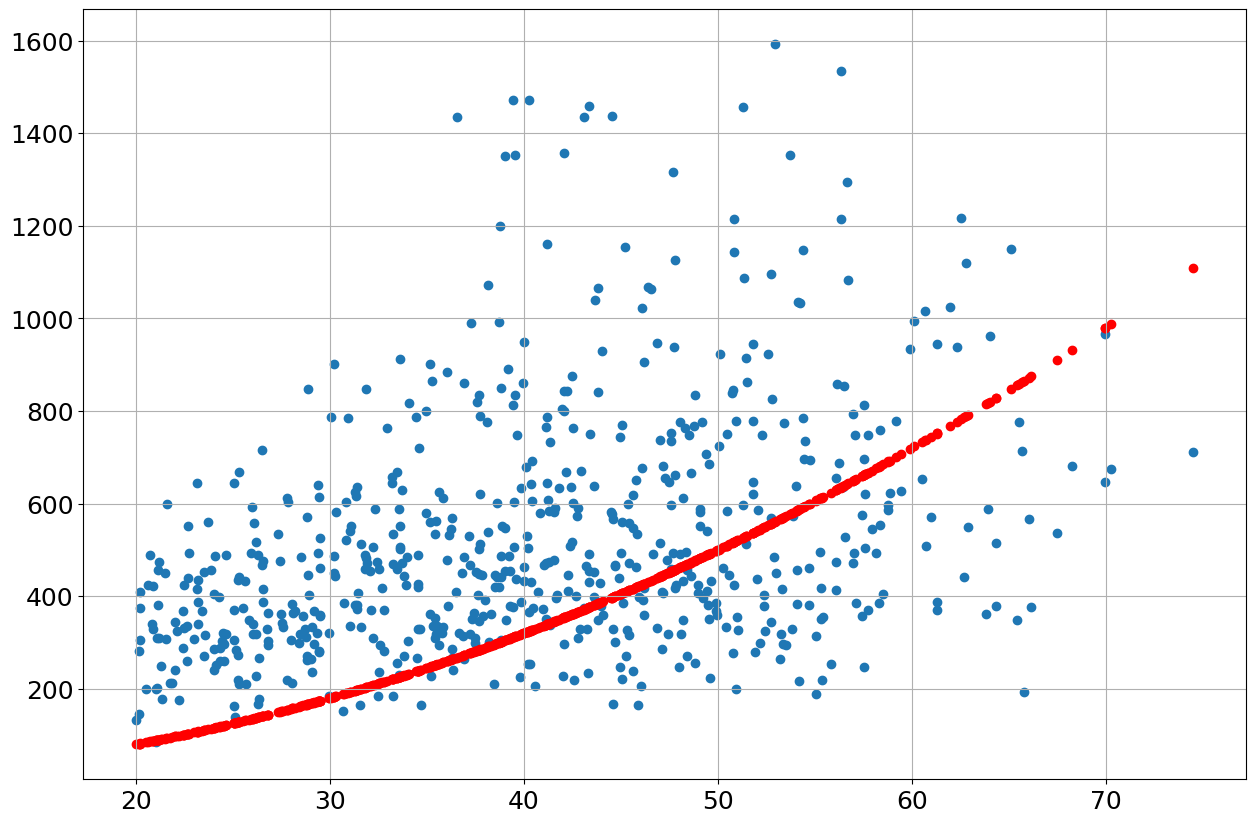

In [11]:
plt.scatter(new_dsg.vmx, new_dsg.K_mean3)
plt.scatter(new_dsg.vmx, new_dsg.vmx ** 2 / 5, color='r')
plt.grid()

In [12]:
# p  = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto50.nc'
# dk = xr.open_dataset(p)
# dk.where(dk.C_sqrtK_K25 > 1.41e-3, drop=True).file_tcva

### 2) Compare with model data

TODO: Filter the higher C values? (for now I only filter out the lower ones)

#### a) K25

In [13]:
p   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto50.nc'
dkg = xr.open_dataset(p)
dk = dkg.where(
    (dkg.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg.dist2coast  > dkg.r34)             & # Distance to coast
    (dkg.percent_outside < 10)              & # Sufficient SAR coverage
    (dkg.vmx > 33)                          & # Test
    (dkg.C_K25 != 0.0001)                   & # Reached the lower bound
    (dkg.asym_avg_err  <= 2.5)              & # Test
    (dkg.phase_avg_err <= 45)               & # Test
    # (dkg.C_sqrtK_K25 > 1.5e-5)              & # Reached the lower bound
    # (dkg.C_sqrtK_K25 < 1.41e-3)             & # Reached the upper bound
    (~xr.where(dkg.non_C1 == 0, False, True)) # Ensure that I > V/r
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg.time))

640


In [14]:
p   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K25_C1C2FIT/dsg_K25_semiFit.nc'
dkg2 = xr.open_dataset(p)
dk2 = dkg2.where(
    (dkg2.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg2.dist2coast  > dkg2.r34)             & # Distance to coast
    (dkg2.percent_outside < 10)              & # Sufficient SAR coverage
    (dkg2.vmx > 33)                          & # Test
    # (dkg2.C_K25 != 0.0001)                   & # Reached the lower bound
    (dkg2.asym_avg_err  <= 2.5)              & # Test
    (dkg2.phase_avg_err <= 45)               & # Test
    # (dkg.C_sqrtK_K25 > 1.5e-5)              & # Reached the lower bound
    # (dkg.C_sqrtK_K25 < 1.41e-3)             & # Reached the upper bound
    (~xr.where(dkg2.non_C1 == 0, False, True)) # Ensure that I > V/r
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg2.time))

640


In [15]:
# plt.scatter(dkg2.c1_K25, dkg2.c2_K25)
# plt.grid()

In [16]:
dk['wght_cont']   = dk.storm_speed_ibt * np.cos(np.deg2rad(dk.storm_dir_ibt)) + dk.vws_pmd * np.cos(np.deg2rad(dk.wsd_pmd))
angles            = (np.rad2deg(np.arctan((dk.c1_K25 / dk.c2_K25))) % 360).copy(deep=True)
angles_bis        = xr.where(angles >= 180, angles, angles + 360)
dk['angles_bis']  = angles_bis

dk2['wght_cont']  = dk2.storm_speed_ibt * np.cos(np.deg2rad(dk2.storm_dir_ibt)) + dk2.vws_pmd * np.cos(np.deg2rad(dk2.wsd_pmd))
angles            = (np.rad2deg(np.arctan((dk2.c1_K25 / dk2.c2_K25))) % 360).copy(deep=True)
angles_bis        = xr.where(angles >= 180, angles, angles + 360)
dk2['angles_bis'] = angles_bis

In [17]:
dsm  = xr.merge([dk, new_dsg], join="inner")
dsm2 = xr.merge([dk2, new_dsg], join="inner")

In [18]:
# ### TODO: Remove
# dk['C_K25'] = dk.C_K25 / np.sqrt(50)

Text(0, 0.5, 'Average Cd (x1e-3)')

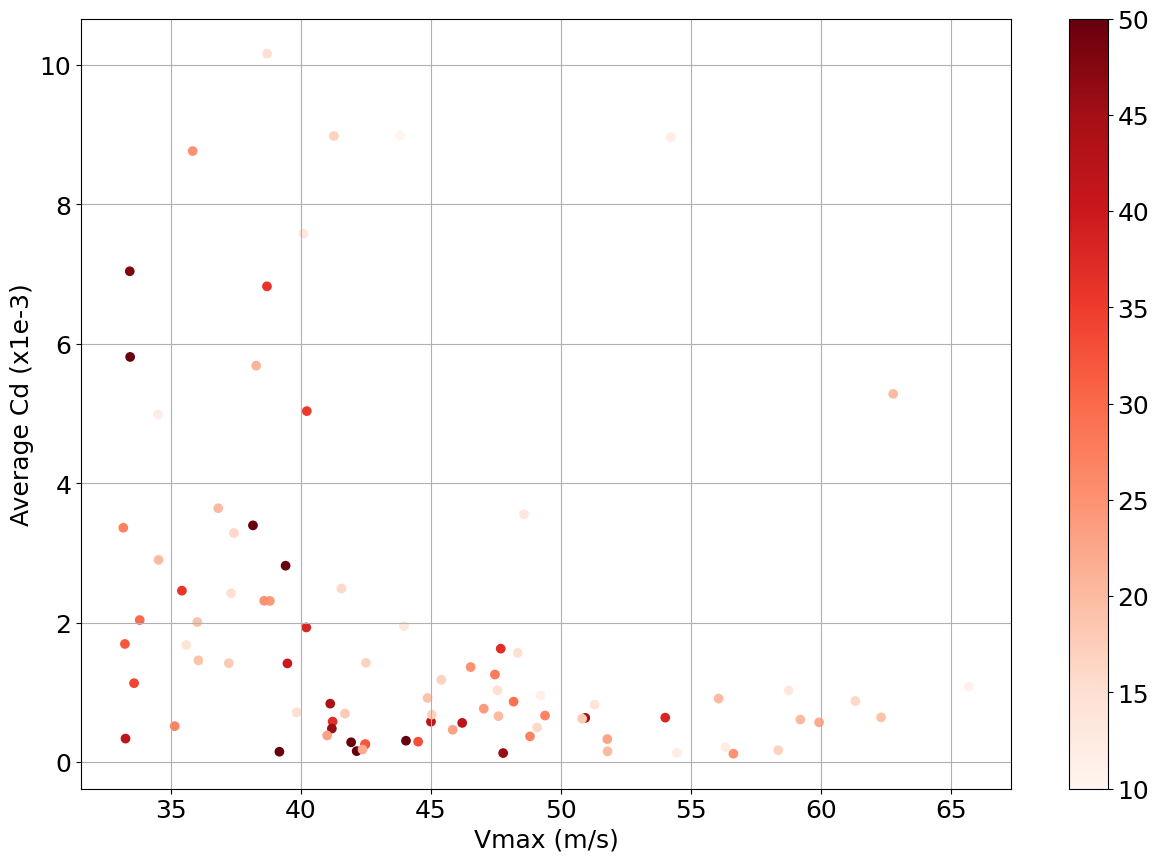

In [19]:
plt.scatter(dk.vmx, dk.C_K25 * 1e3, c=dk.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
# plt.ylim(1, 4)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

Text(0, 0.5, 'Average Cd (x1e-3)')

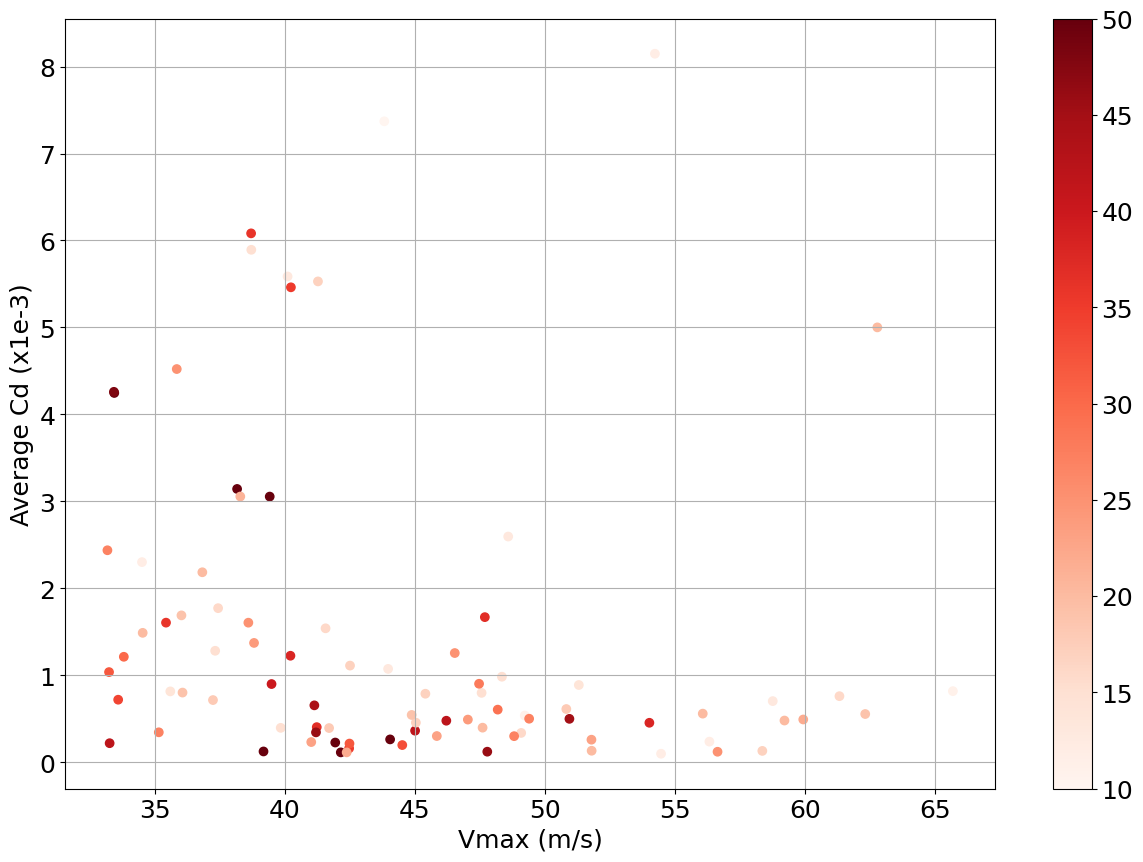

In [20]:
plt.scatter(dsm.vmx, np.sqrt(dsm.K_mean3) / 5 * dsm.C_sqrtK_K25 * 1e3, c=dsm.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
# plt.ylim(1, 4)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

In [21]:
# plt.scatter(dk.speed, np.sqrt(dk.c1_K25 ** 2 + dk.c2_K25 ** 2))

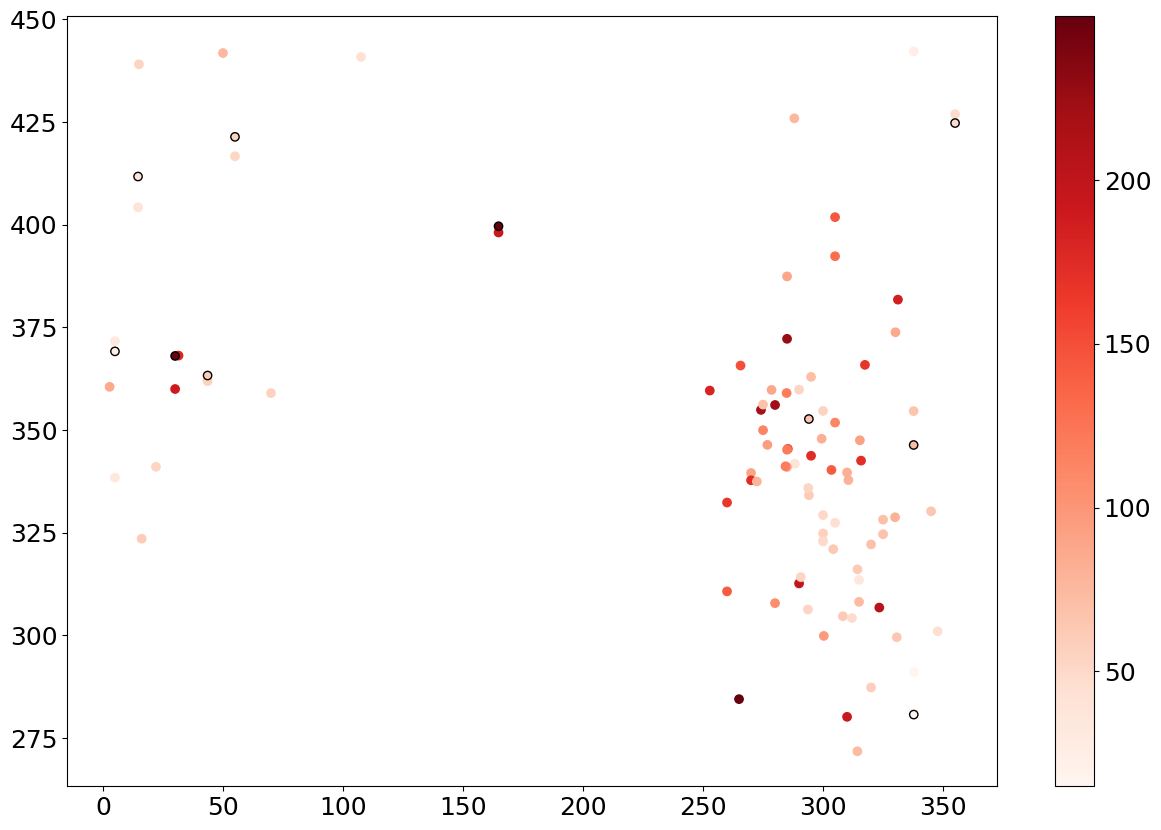

In [22]:
plt.scatter(dk.storm_dir_ibt, dk.angles_bis, c=dk.wsd_pmd,                                                                   cmap=plt.get_cmap('Reds'))
plt.scatter(dk.storm_dir_ibt.where(dk.vws_pmd > 10), angles_bis.where(dk.vws_pmd > 10), c=dk.wsd_pmd.where(dk.vws_pmd > 10), cmap=plt.get_cmap('Reds'), edgecolors='k')
plt.colorbar()

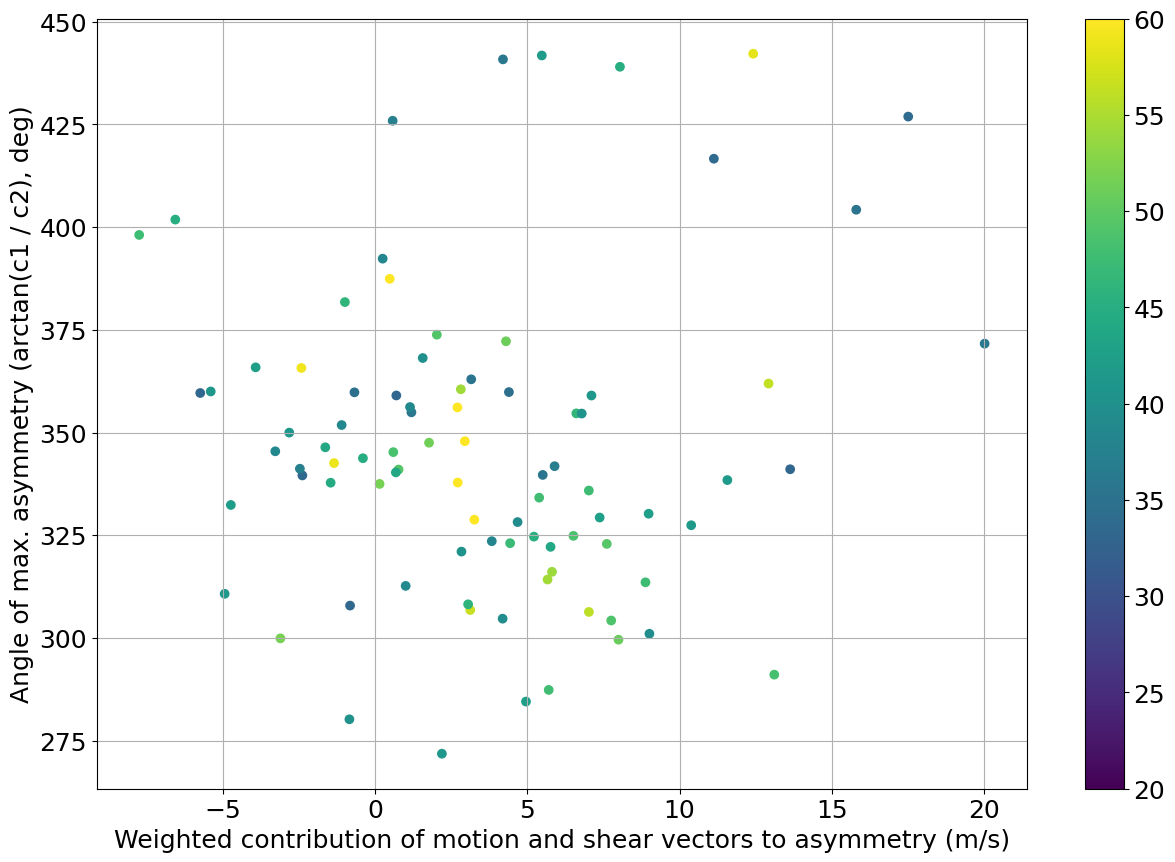

In [23]:
# c1 / c2 as a function of relative contribution from shear and motion vectors
# NB: les outliers en haut semblent normaux
# NB: l'outlier tout à gauche à un Vmax très faible, proche de 20 m/s
plt.scatter(dk.wght_cont, dk.angles_bis, c=dk.vmx, vmin=20, vmax=60)
plt.colorbar()
plt.xlabel('Weighted contribution of motion and shear vectors to asymmetry (m/s)')
plt.ylabel('Angle of max. asymmetry (arctan(c1 / c2), deg)')
plt.grid()

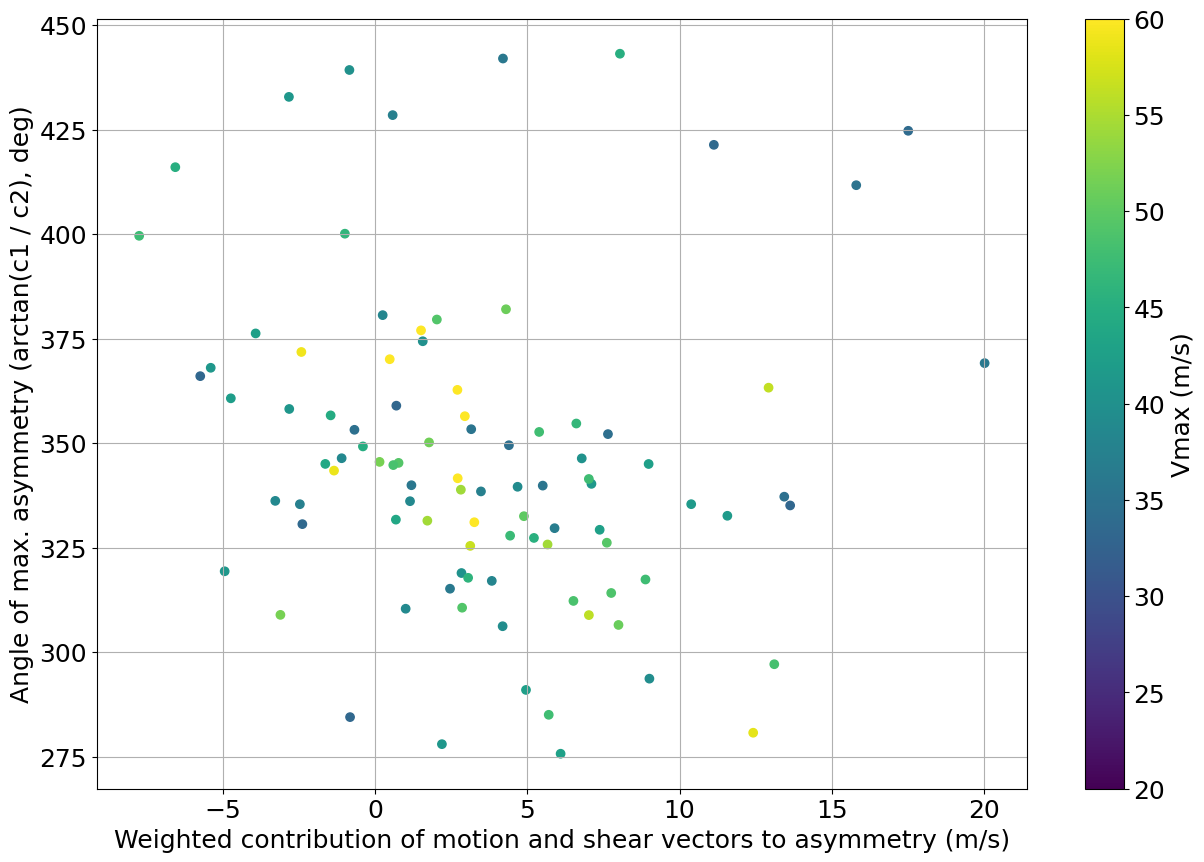

In [168]:
# c1 / c2 as a function of relative contribution from shear and motion vectors
plt.scatter(dk2.wght_cont, dk2.angles_bis, c=dk2.vmx, vmin=20, vmax=60)
plt.colorbar(label='Vmax (m/s)')
plt.xlabel('Weighted contribution of motion and shear vectors to asymmetry (m/s)')
plt.ylabel('Angle of max. asymmetry (arctan(c1 / c2), deg)')
plt.grid()

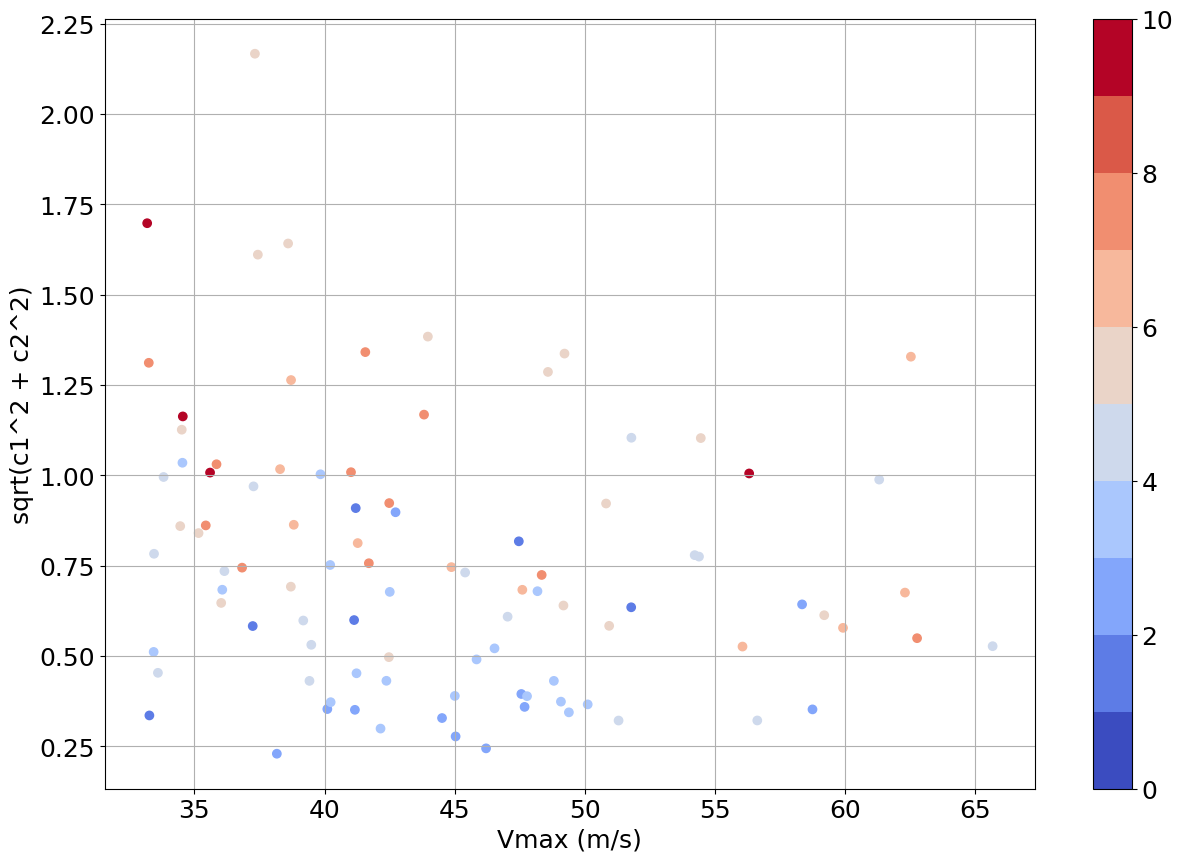

In [25]:
plt.scatter(dk2.vmx, np.sqrt(dk2.c1_K25 ** 2 + dk2.c2_K25 ** 2), c=dk2.speed, cmap=plt.get_cmap('coolwarm', 10), vmin=0, vmax=10)
plt.xlabel('Vmax (m/s)')
plt.ylabel('sqrt(c1^2 + c2^2)')
plt.grid()
plt.colorbar()

##### ==> Motion dominates the asymmetric response of the boundary layer, even in presence of strong wind shear.

Complementary to the result of Corbosiero and Molinari that wind shear dominates the convective asymmetry. 

In [155]:
# plt.scatter(dk2.speed, np.sqrt(dk2.c1_K25 ** 2 + dk2.c2_K25 ** 2), c=dk2.vws_pmd, cmap=plt.get_cmap('coolwarm', 9), vmin=3, vmax=12)
# plt.xlabel('Storm motion (m/s)')
# plt.ylabel('sqrt(c1^2 + c2^2)')
# plt.grid()
# plt.colorbar(label='Wind shear (m/s)')

In [154]:
### TEST

# Update Southern hemisphere storms
dk2['storm_dir_adjusted']                    = dk2['storm_dir_ibt'].copy(deep=True)
dk2['storm_dir_adjusted'][dk2.lat < 0]  += 180

dsa1 = dk2.where(((dk2.vws_pmd - dk2.storm_dir_adjusted) % 360 >= 0)   & ((dk2.vws_pmd - dk2.storm_dir_adjusted) % 360 <= 90),  drop=True).dropna(dim='time', how='all')
dsa2 = dk2.where(((dk2.vws_pmd - dk2.storm_dir_adjusted) % 360 >= 90)  & ((dk2.vws_pmd - dk2.storm_dir_adjusted) % 360 <= 180), drop=True).dropna(dim='time', how='all')
dsa3 = dk2.where(((dk2.vws_pmd - dk2.storm_dir_adjusted) % 360 >= 180) & ((dk2.vws_pmd - dk2.storm_dir_adjusted) % 360 <= 270), drop=True).dropna(dim='time', how='all')
dsa4 = dk2.where(((dk2.vws_pmd - dk2.storm_dir_adjusted) % 360 >= 270) & ((dk2.vws_pmd - dk2.storm_dir_adjusted) % 360 <= 360), drop=True).dropna(dim='time', how='all')

print(float(dsa1.rmx.mean()))
print(float(dsa2.rmx.mean()))
print(float(dsa3.rmx.mean()))
print(float(dsa4.rmx.mean()))

27054.054054054053
36000.0
23500.0
29400.0


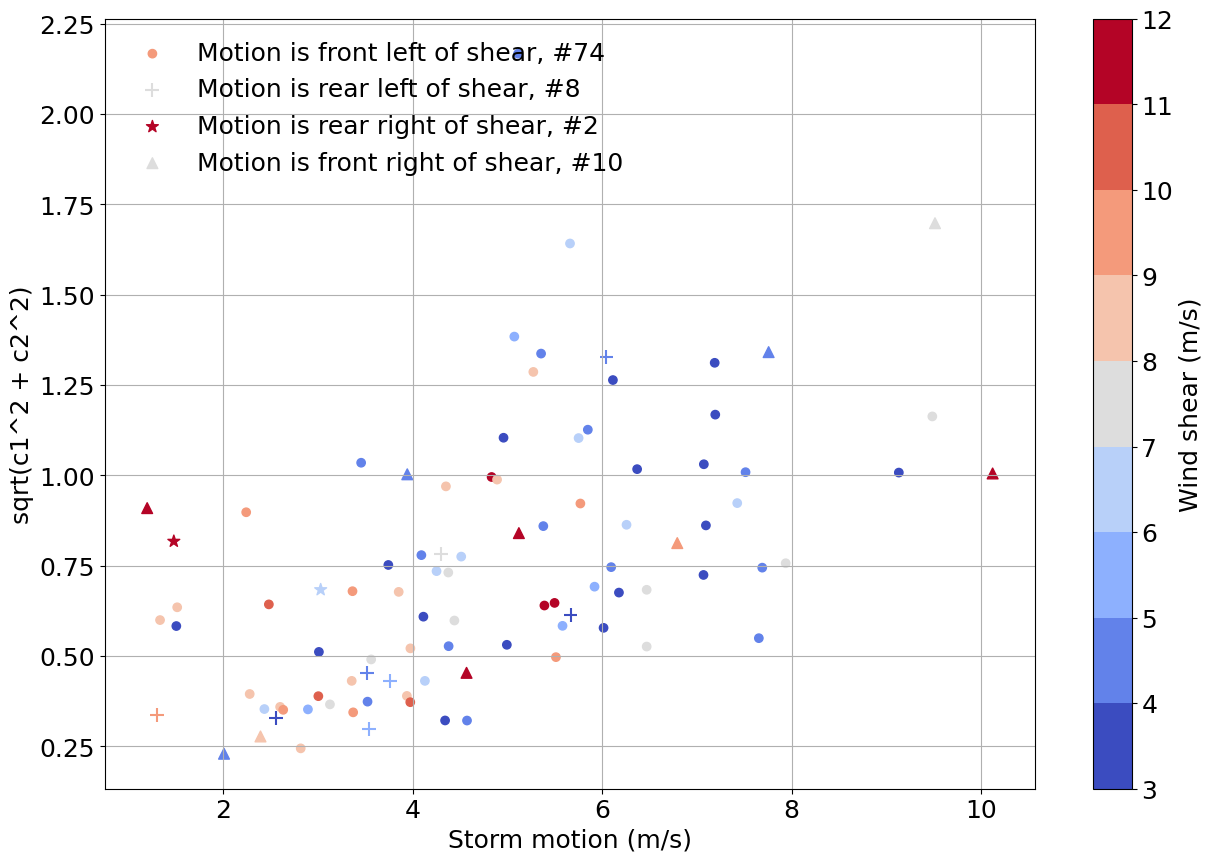

In [166]:
plt.scatter(dsa1.speed, np.sqrt(dsa1.c1_K25 ** 2 + dsa1.c2_K25 ** 2), c=dsa1.vws_pmd, cmap=plt.get_cmap('coolwarm', 9),        vmin=3, vmax=12, marker='o', label='Motion is front left of shear, #{}'.format(len(dsa1.time)))
plt.scatter(dsa2.speed, np.sqrt(dsa2.c1_K25 ** 2 + dsa2.c2_K25 ** 2), c=dsa2.vws_pmd, cmap=plt.get_cmap('coolwarm', 9), s=100, vmin=3, vmax=12, marker='+', label='Motion is rear left of shear, #{}'.format(len(dsa2.time)))
plt.scatter(dsa3.speed, np.sqrt(dsa3.c1_K25 ** 2 + dsa3.c2_K25 ** 2), c=dsa3.vws_pmd, cmap=plt.get_cmap('coolwarm', 9), s=80,  vmin=3, vmax=12, marker='*', label='Motion is rear right of shear, #{}'.format(len(dsa3.time)))
plt.scatter(dsa4.speed, np.sqrt(dsa4.c1_K25 ** 2 + dsa4.c2_K25 ** 2), c=dsa4.vws_pmd, cmap=plt.get_cmap('coolwarm', 9), s=60,  vmin=3, vmax=12, marker='^', label='Motion is front right of shear, #{}'.format(len(dsa4.time)))

plt.xlabel('Storm motion (m/s)')
plt.ylabel('sqrt(c1^2 + c2^2)')
plt.grid()
plt.colorbar(label='Wind shear (m/s)')
plt.legend(frameon=False, loc='upper left')

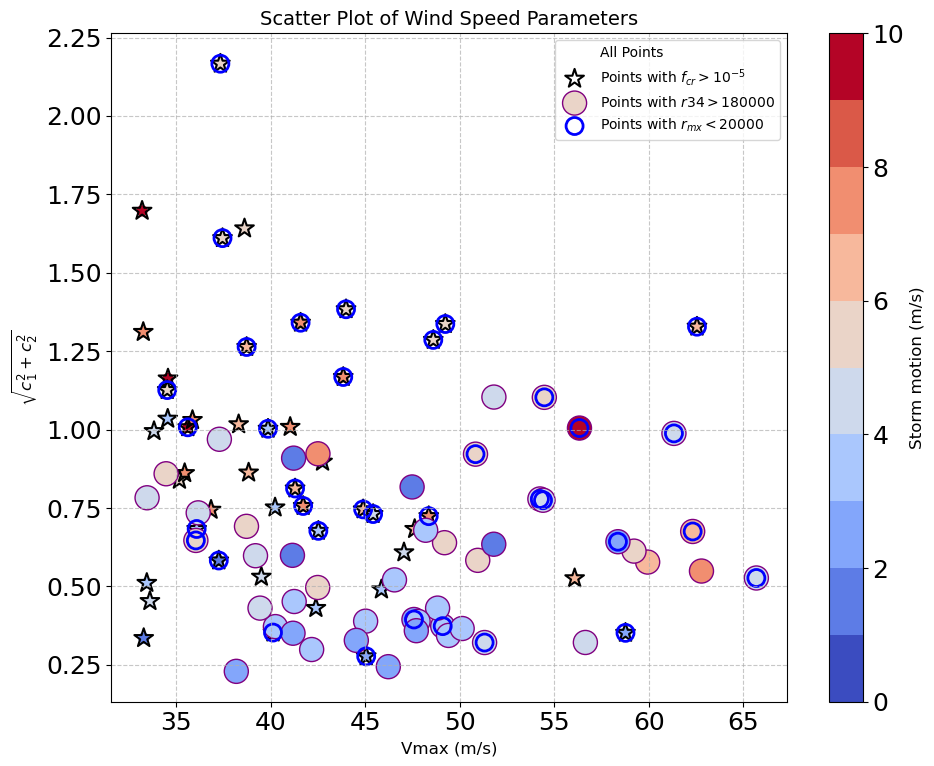

In [26]:
### CAVEAT
### This figure was done with Gemini and is wrong!!!
### It's just to illustrate
### Re-do it nicely.

dk2['sqrt_c1c2'] = np.sqrt(dk2.c1_K25 ** 2 + dk2.c2_K25 ** 2)

# --- Tracé ---
plt.figure(figsize=(10, 8))

# 1. Tracé de tous les points en tant que couche de base
# Nous utilisons .values pour extraire les tableaux NumPy sous-jacents,
# ce qui est une bonne pratique pour les fonctions Matplotlib qui attendent des ndarrays.
scatter_base = plt.scatter(dk2['vmx'].values, dk2['sqrt_c1c2'].values,
                           c=dk2['speed'].values, cmap=plt.get_cmap('coolwarm', 10),
                           vmin=0, vmax=10, s=50, label='All Points')

# 2. Marquer les points où fcr > 1e-5 avec des étoiles
# Le filtrage avec Xarray s'effectue directement sur le DataArray ou le Dataset.
# On utilise .where() pour conserver les dimensions et gérer les NaN,
# ou on peut filtrer directement et extraire les valeurs non-NaN.
dk2_stars = dk2.where(dk2['fcor'] > 1e-5, drop=True) # drop=True pour ne garder que les points qui satisfont la condition
plt.scatter(dk2_stars['vmx'].values, dk2_stars['sqrt_c1c2'].values,
                facecolors='none',
                edgecolors='black',
                marker='*',
                s=200,
                linewidths=1.5,
                label=r'Points with $f_{cr} > 10^{-5}$')

# 3. Augmenter la taille des points où fcr.r34 > 180000
dk2_large_size = dk2.where(dk2['r34'] > 180000, drop=True)
plt.scatter(dk2_large_size['vmx'].values, dk2_large_size['sqrt_c1c2'].values,
                c=dk2_large_size['speed'].values,
                cmap=plt.get_cmap('coolwarm', 10),
                vmin=0, vmax=10,
                s=300,
                edgecolors='purple',
                linewidths=1,
                label=r'Points with $r34 > 180000$')

# 4. Entourer les points pour lesquels dk2.rmx < 20000
dk2_encircled = dk2.where(dk2['rmx'] < 20000, drop=True)
plt.scatter(dk2_encircled['vmx'].values, dk2_encircled['sqrt_c1c2'].values,
                facecolors='none',
                edgecolors='blue',
                marker='o',
                s=150,
                linewidths=2,
                label=r'Points with $r_{mx} < 20000$')

# --- Ajout des labels, titre, grille et barre de couleur ---
plt.xlabel('Vmax (m/s)', fontsize=12)
plt.ylabel(r'$\sqrt{c_1^2 + c_2^2}$', fontsize=12)
plt.title('Scatter Plot of Wind Speed Parameters', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Ajout d'une barre de couleur
cbar = plt.colorbar(scatter_base)
cbar.set_label('Storm motion (m/s)', fontsize=12)

# Ajout d'une légende
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

#### b) K01

In [27]:
# plt.hist((dkg01.storm_speed_ibt / dkg01.vws_pmd), bins=100)
# plt.xlim(0, 2)
# plt.grid()

In [28]:
p   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto50.nc'
# p   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/old/dsg_K01_withKsetto50_wrongSouthernHemisphere.nc'
dkg01 = xr.open_dataset(p)
dk01 = dkg01.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01.dist2coast  > dkg01.r34)             & # Distance to coast
    (dkg01.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg01.vmx > 20)                            & # Test
    (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
    (dkg01.C_K01 != 0.1)                        & # Reached the upper bound
    (dkg01.asym_avg_err  <= 2.5)                & # Test
    (dkg01.phase_avg_err <= 45)                 & # Test
    (~xr.where(dkg01.non_C1 == 0, False, True)) & # Ensure that I > V/r
    ((dkg01.storm_speed_ibt / dkg01.vws_pmd) > 1) # Ratio storm_speed / wind_shead
)
print(len(dkg01.time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

640


Text(0, 0.5, 'Average Cd (x1e-3)')

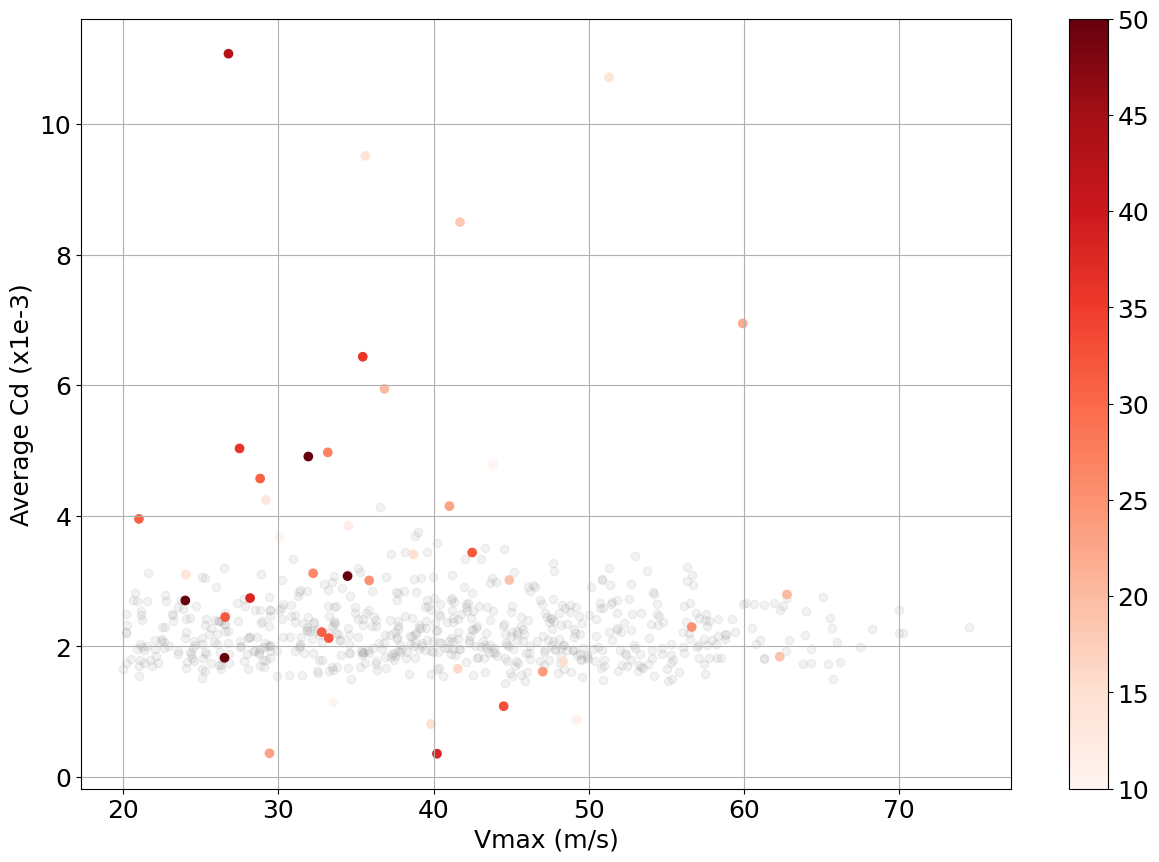

In [29]:
dsm01 = xr.merge([dk01, new_dsg], join="inner")
plt.scatter(dsm01.vmx, dsm01.cd_mean_lp * 1e3, c='gray', alpha=0.1)
plt.scatter(dsm01.vmx, np.sqrt(dsm01.K_mean_kpp) * dsm01.C_sqrtK_K01 * 1e3, c=dsm01.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
# plt.ylim(1, 4)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

Text(0, 0.5, 'Estimated K (m2/s)')

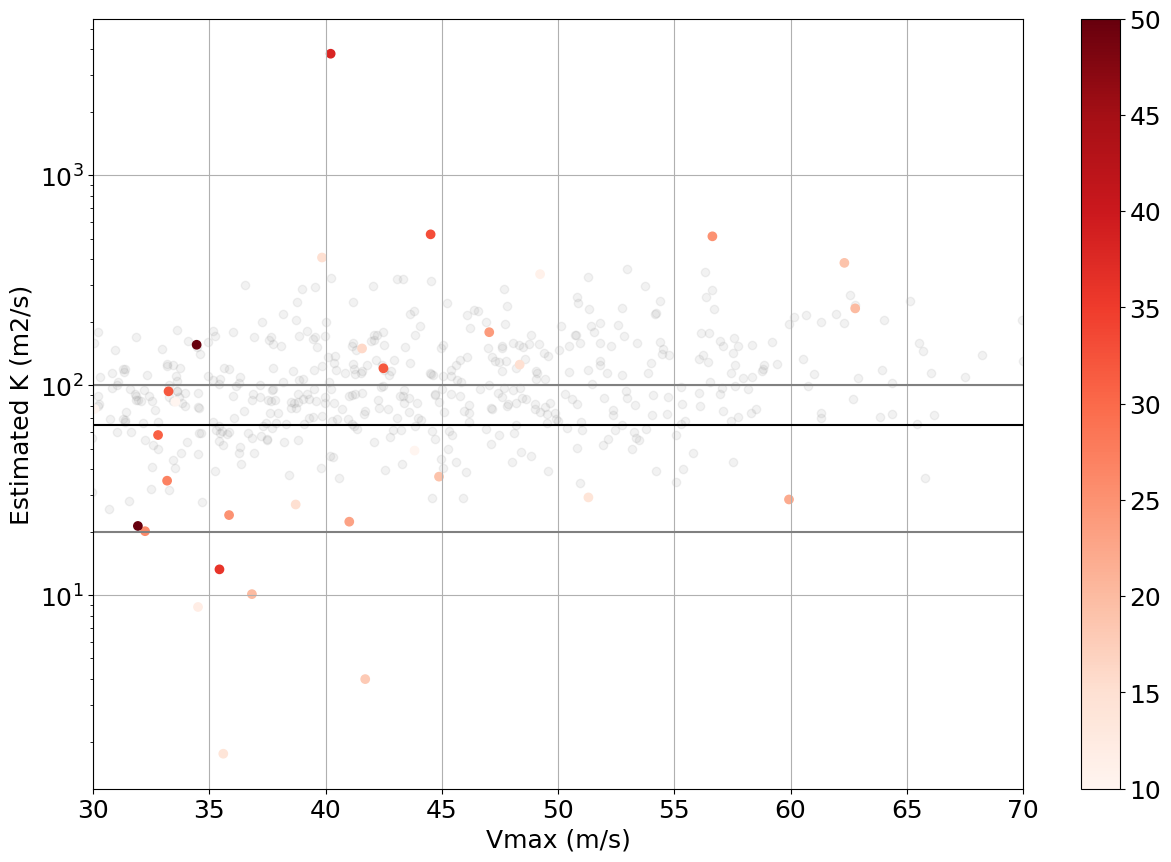

In [30]:
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
plt.scatter(dsm01.vmx, dsm01.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm01.vmx, (dsm01.cd_mean_lp / dsm01.C_sqrtK_K01) ** 2, c=dsm01.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
# plt.ylim(-100, 4000)
plt.yscale('log')
# plt.ylim(-10, 200)
plt.xlim(30, 70)
plt.axhline(100, c='gray')
plt.axhline(65,  c='k')
plt.axhline(20,  c='gray')
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Estimated K (m2/s)')

Text(0, 0.5, 'Cd (K01)')

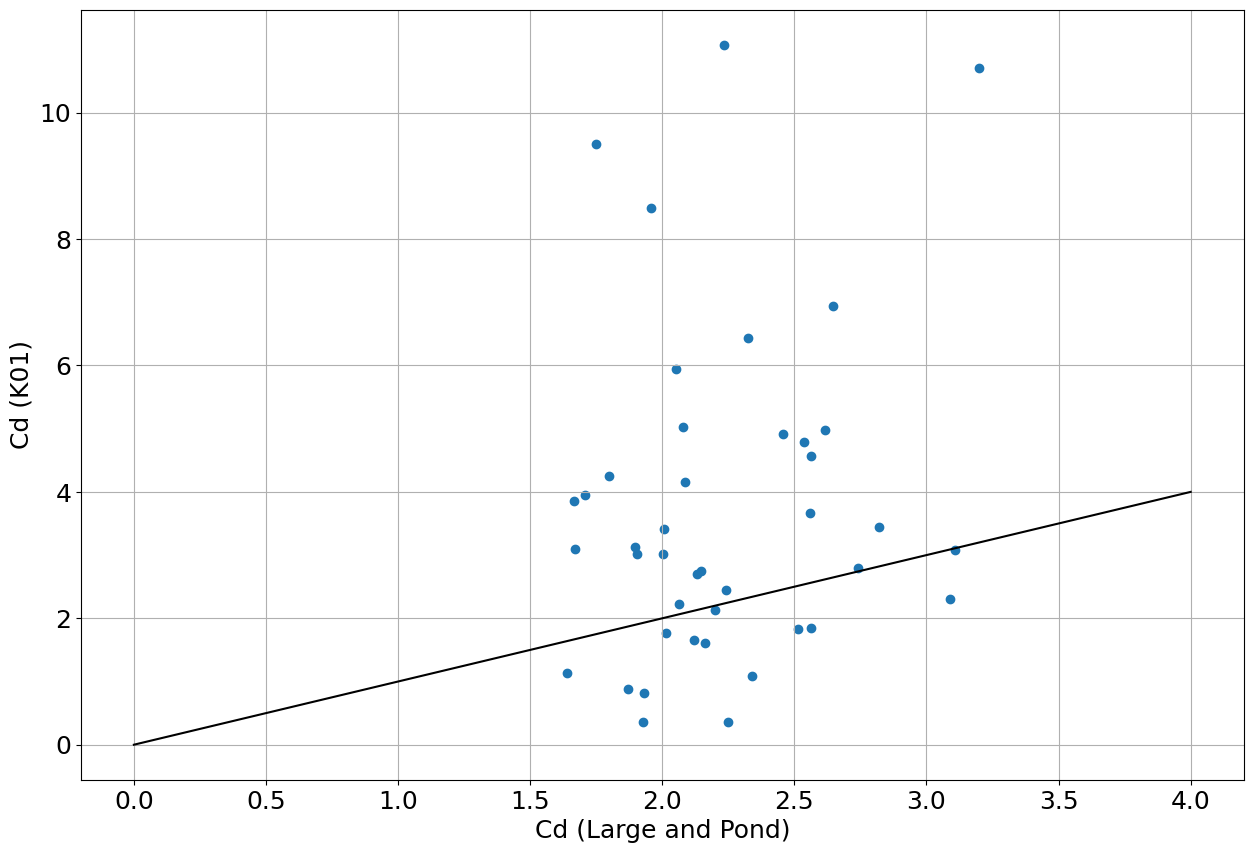

In [31]:
dsm_bis = xr.merge([dk, dk01, new_dsg], join="inner", compat='override')

plt.scatter(dsm_bis.cd_mean_lp * 1e3, np.sqrt(dsm01.K_mean_kpp) * dsm01.C_sqrtK_K01 * 1e3)
plt.plot([0, 4], [0, 4], c='k')
# plt.ylim(0, 600)
plt.grid()
plt.xlabel('Cd (Large and Pond)')
plt.ylabel('Cd (K01)')

In [32]:
# plt.hist(dsm_bis.where(np.sqrt(dsm01.K_mean_kpp) * dsm01.C_sqrtK_K01 * 1e3 > 4, drop=True).asym_avg_err, alpha=0.3)
# plt.hist(dsm_bis.where(np.sqrt(dsm01.K_mean_kpp) * dsm01.C_sqrtK_K01 * 1e3 < 4, drop=True).asym_avg_err, alpha=0.3)
# plt.hist(dsm_bis.asym_avg_err, alpha=0.3, color='gray')

In [33]:
# plt.hist(dsm_bis.where(np.sqrt(dsm01.K_mean_kpp) * dsm01.C_sqrtK_K01 * 1e3 > 4, drop=True).asym_diff, alpha=0.3)
# plt.hist(dsm_bis.where(np.sqrt(dsm01.K_mean_kpp) * dsm01.C_sqrtK_K01 * 1e3 < 4, drop=True).asym_diff, alpha=0.3)
# plt.hist(dsm_bis.asym_diff, alpha=0.3, color='gray')

Text(0, 0.5, 'K (K01)')

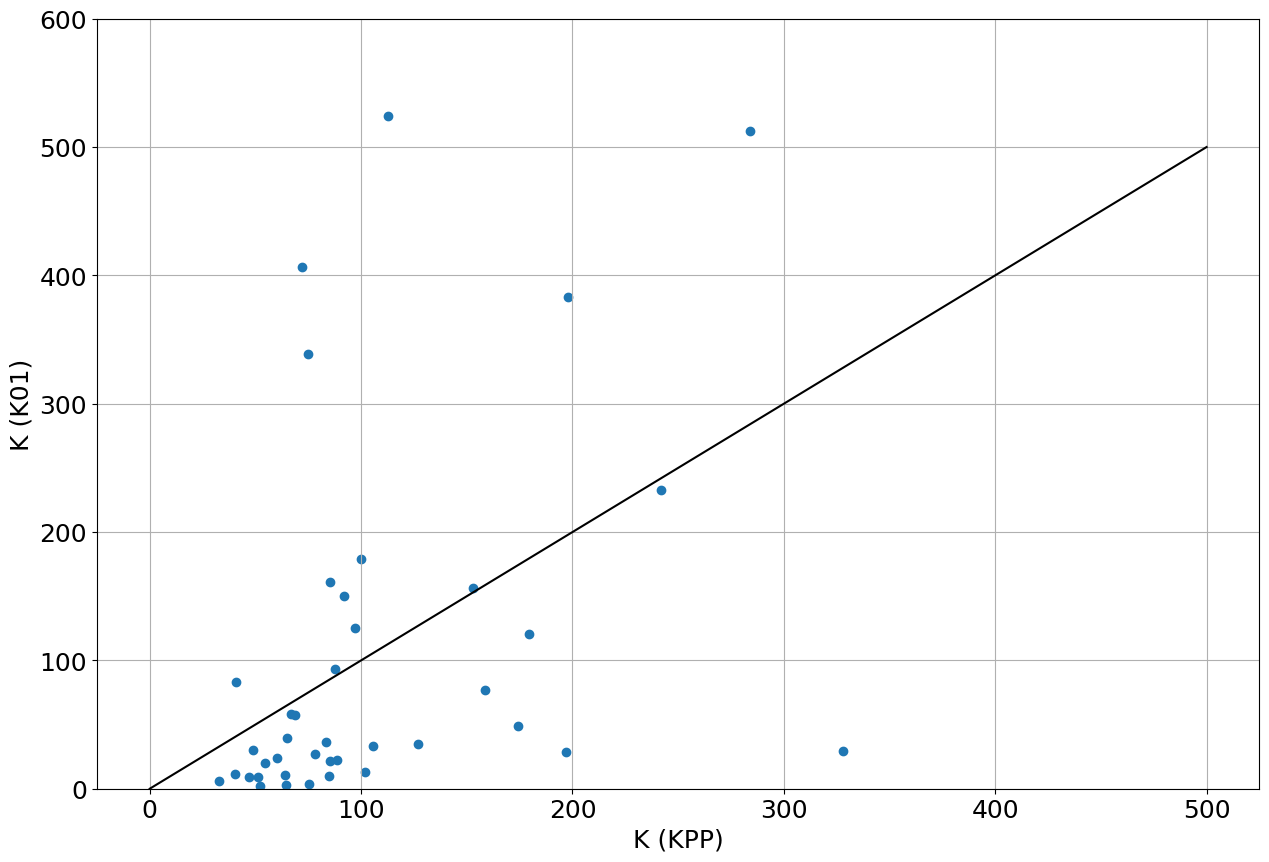

In [34]:
plt.scatter(dsm_bis.K_mean_kpp, (dsm01.cd_mean_lp / dsm01.C_sqrtK_K01) ** 2)
plt.plot([0, 500], [0, 500], c='k')
plt.ylim(0, 600)
plt.grid()
plt.xlabel('K (KPP)')
plt.ylabel('K (K01)')

Text(0, 0.5, 'K (K25)')

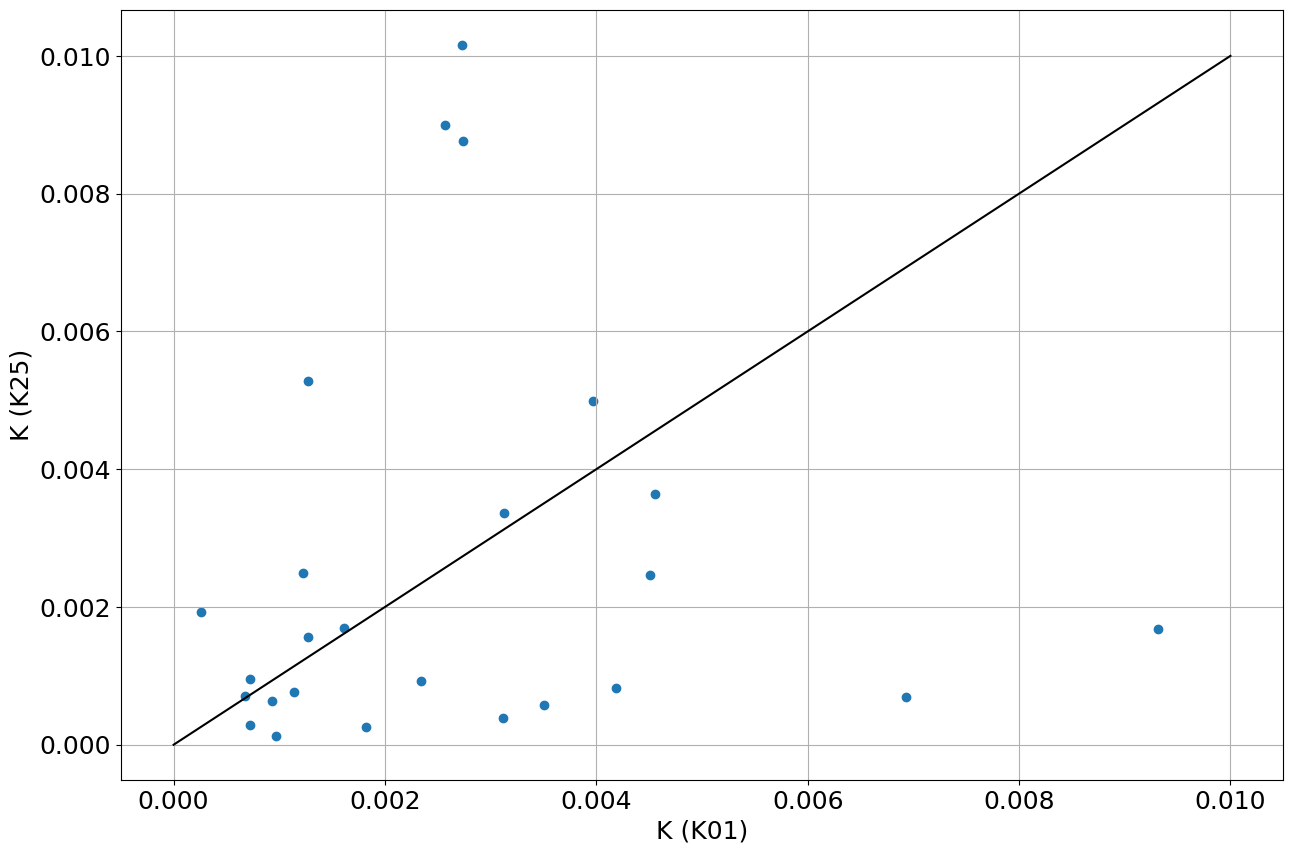

In [35]:
plt.scatter(dsm_bis.C_K01, dsm_bis.C_K25)
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.grid()
plt.xlabel('K (K01)')
plt.ylabel('K (K25)')

#### c) K01 wINFLOW_ANGLE

In [36]:
p   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto50.nc'
dkg01ia = xr.open_dataset(p)
dk01ia = dkg01ia.where(
    # (dkg01.lat > 0) &                                 # Northern hemisphere; Remove this filter?
    (dkg01ia.dist2coast  > dkg01ia.r34)               & # Distance to coast
    (dkg01ia.percent_outside < 10)                    & # Sufficient SAR coverage
    (dkg01ia.vmx > 20)                                & # Test
    (dkg01ia.C_K01 != 0.0001)                         & # Reached the lower bound
    (dkg01ia.C_K01 != 0.1)                            & # Reached the upper bound
    (dkg01ia.asym_avg_err  <= 2.5)                    & # Test
    (dkg01ia.phase_avg_err <= 45)                     & # Test
    (~xr.where(dkg01ia.non_C1 == 0, False, True))     & # Ensure that I > V/r
    ((dkg01ia.storm_speed_ibt / dkg01ia.vws_pmd) > 1) & # Ratio storm_speed / wind_shead

    (dkg01ia.ratio_of_valid_scat_values > 0.9)          # Only for fits involving scat inflow angle estimates    
)
print(len(dkg01ia.time))

79


Text(0, 0.5, 'Average Cd (x1e-3)')

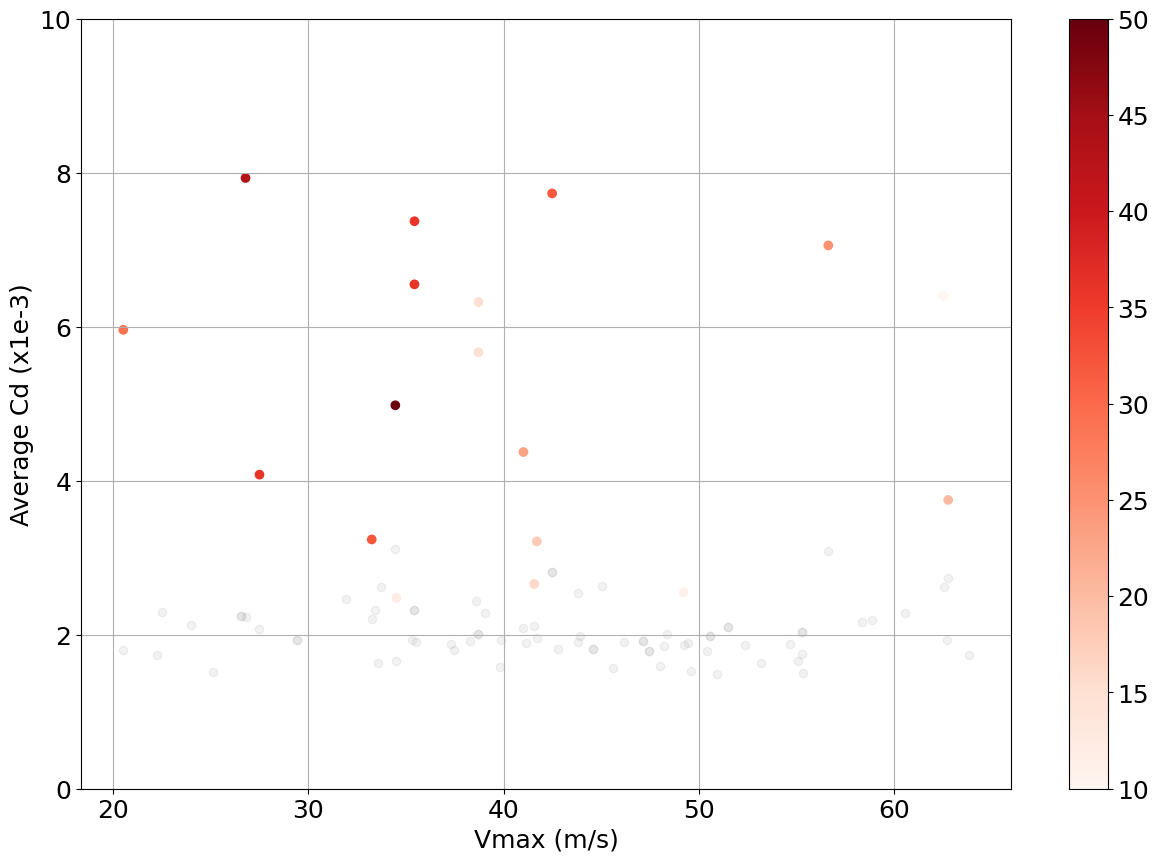

In [37]:
dsm01ia = xr.merge([new_dsg.sel(time=dk01ia.time), dk01ia], join="inner")
plt.scatter(dsm01ia.vmx, dsm01ia.cd_mean_lp * 1e3, c='gray', alpha=0.1)
plt.scatter(dsm01ia.vmx, np.sqrt(dsm01ia.K_mean_kpp) * dsm01ia.C_sqrtK_K01 * 1e3, c=dsm01ia.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
plt.ylim(0, 10)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

Text(0, 0.5, 'Estimated K (m2/s)')

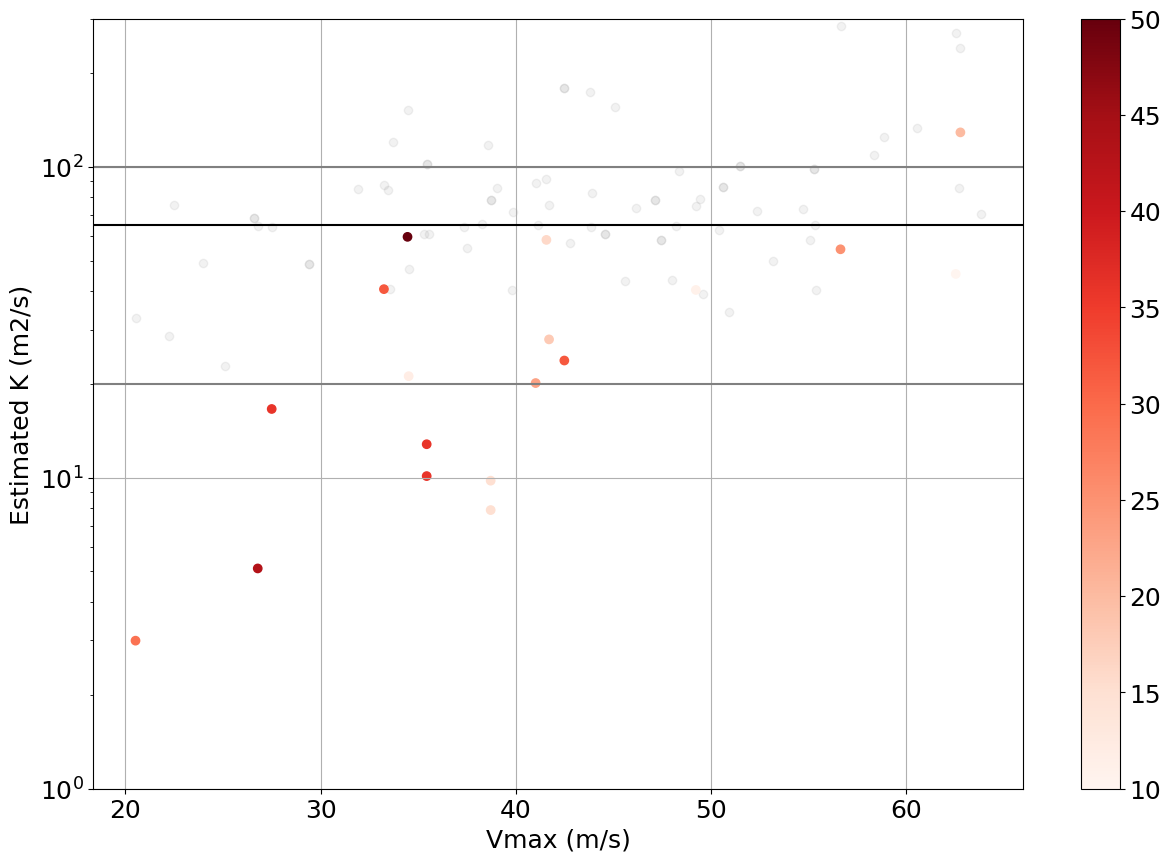

In [38]:
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
plt.scatter(dsm01ia.vmx, dsm01ia.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm01ia.vmx, (dsm01ia.cd_mean_lp / dsm01ia.C_sqrtK_K01) ** 2, c=dsm01ia.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
# plt.ylim(-100, 4000)
plt.ylim(1, 300)
plt.yscale('log')
# plt.xlim(30, 70)
plt.axhline(100, c='gray')
plt.axhline(65,  c='k')
plt.axhline(20,  c='gray')
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Estimated K (m2/s)')

#### d) K25 wINFLOW_ANGLE

In [143]:
p   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto50.nc'
dkg25ia = xr.open_dataset(p)
dk25ia = dkg25ia.where(
    # (dkg25.lat > 0) &                                 # Northern hemisphere; Remove this filter?
    (dkg25ia.dist2coast  > dkg25ia.r34)               & # Distance to coast
    (dkg25ia.percent_outside < 10)                    & # Sufficient SAR coverage
    (dkg25ia.vmx > 20)                                & # Test
    (dkg25ia.C_K25 != 0.0025)                         & # Reached the lower bound
    (dkg25ia.C_K25 != 0.1)                            & # Reached the upper bound
    (dkg25ia.asym_avg_err  <= 2.5)                    & # Test
    (dkg25ia.phase_avg_err <= 45)                     & # Test
    (~xr.where(dkg25ia.non_C1 == 0, False, True))     & # Ensure that I > V/r
    ((dkg25ia.storm_speed_ibt / dkg25ia.vws_pmd) > 1) & # Ratio storm_speed / wind_shead

    (dkg25ia.ratio_of_valid_scat_values > 0.9)          # Only for fits involving scat inflow angle estimates    
)
print(len(dkg25ia.time))

79


Text(0, 0.5, 'Average Cd (x1e-3)')

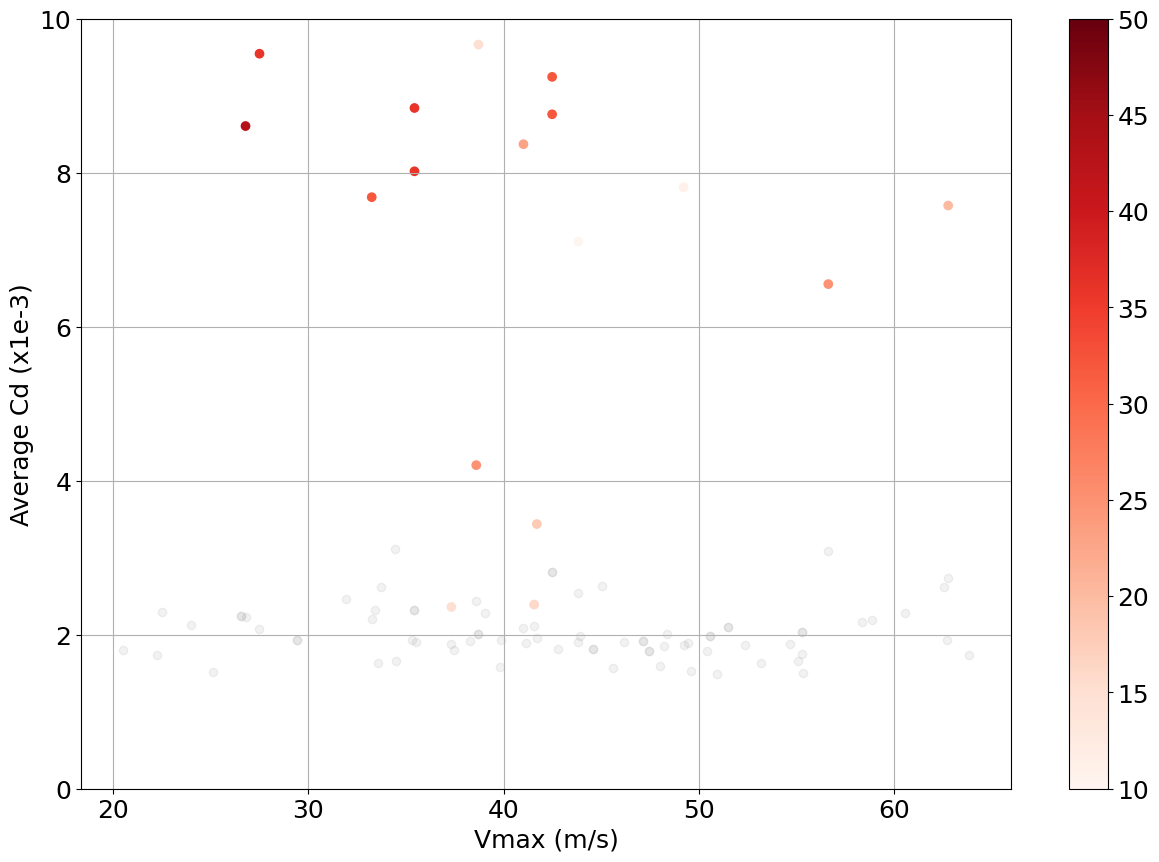

In [144]:
dsm25ia = xr.merge([new_dsg.sel(time=dk25ia.time), dk25ia], join="inner")
plt.scatter(dsm25ia.vmx, dsm25ia.cd_mean_lp * 1e3, c='gray', alpha=0.1)
plt.scatter(dsm25ia.vmx, np.sqrt(dsm25ia.K_mean_kpp) * dsm25ia.C_sqrtK_K25 * 1e3, c=dsm25ia.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
plt.ylim(0, 10)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

Text(0, 0.5, 'Estimated K (m2/s)')

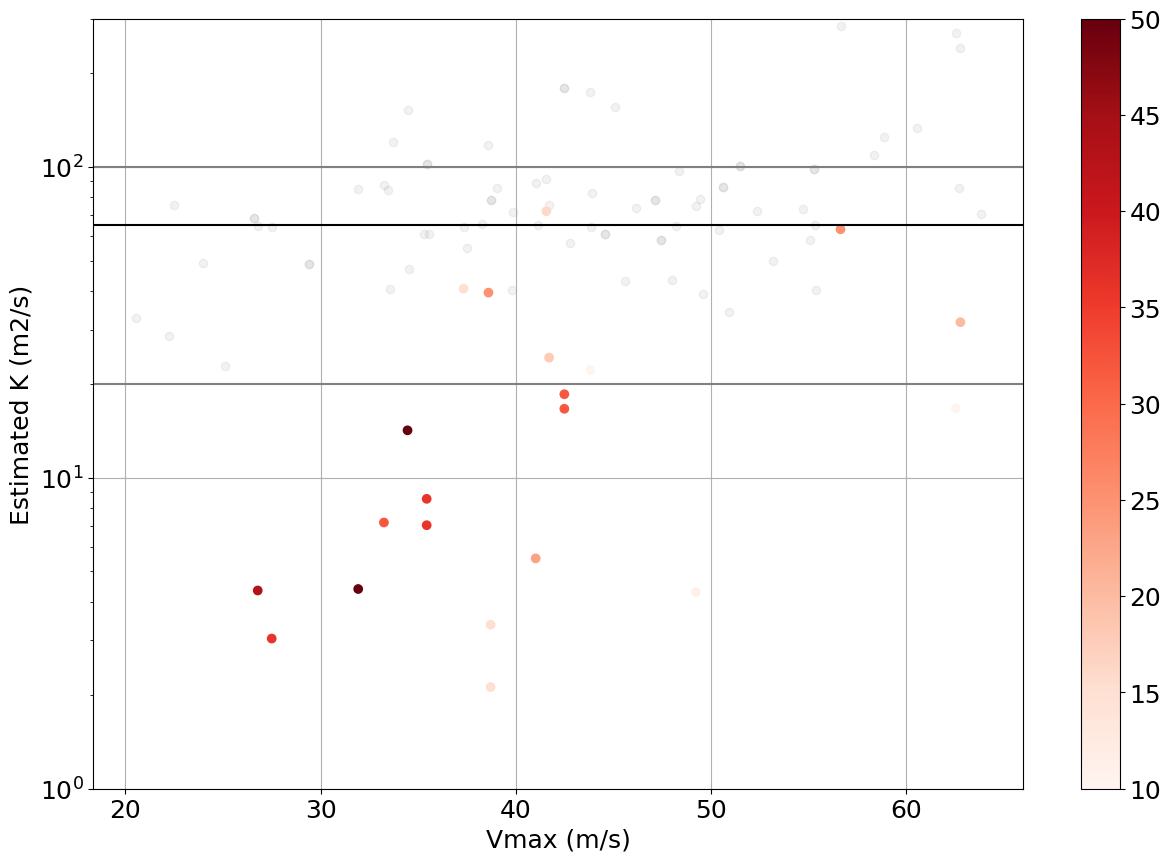

In [138]:
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
plt.scatter(dsm25ia.vmx, dsm25ia.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm25ia.vmx, (dsm25ia.cd_mean_lp / dsm25ia.C_sqrtK_K25) ** 2, c=dsm25ia.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
# plt.ylim(-100, 4000)
plt.ylim(1, 300)
plt.yscale('log')
# plt.xlim(30, 70)
plt.axhline(100, c='gray')
plt.axhline(65,  c='k')
plt.axhline(20,  c='gray')
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Estimated K (m2/s)')

In [148]:
# dsm25ia['wght_cont']   = dsm25ia.storm_speed_ibt * np.cos(np.deg2rad(dsm25ia.storm_dir_ibt)) + dsm25ia.vws_pmd * np.cos(np.deg2rad(dsm25ia.wsd_pmd))
# angles                 = (np.rad2deg(np.arctan((dsm25ia.c1_K25 / dsm25ia.c2_K25))) % 360).copy(deep=True)
# angles_bis             = xr.where(angles >= 180, angles, angles + 360)
# dsm25ia['angles_bis']  = angles_bis

# plt.scatter(dsm25ia.wght_cont, dsm25ia.angles_bis, c=dsm25ia.vmx, vmin=20, vmax=60)
# plt.colorbar()
# plt.xlabel('Weighted contribution of motion and shear vectors to asymmetry (m/s)')
# plt.ylabel('Angle of max. asymmetry (arctan(c1 / c2), deg)')
# plt.grid()
# plt.show()

# plt.scatter(dsm25ia.vmx, np.sqrt(dsm25ia.c1_K25 ** 2 + dsm25ia.c2_K25 ** 2), c=dsm25ia.speed, cmap=plt.get_cmap('coolwarm', 6), vmin=3, vmax=9)
# plt.xlabel('Vmax (m/s)')
# plt.ylabel('sqrt(c1^2 + c2^2)')
# plt.grid()
# plt.colorbar()
# plt.show()

In [147]:
# ### TEST

# # Update Southern hemisphere storms
# dsm25ia['storm_dir_adjusted']                    = dsm25ia['storm_dir_ibt'].copy(deep=True)
# dsm25ia['storm_dir_adjusted'][dsm25ia.lat < 0]  += 180

# dsa1 = dsm25ia.where(((dsm25ia.vws_pmd - dsm25ia.storm_dir_adjusted) % 360 >= 0)   & ((dsm25ia.vws_pmd - dsm25ia.storm_dir_adjusted) % 360 <= 90),  drop=True).dropna(dim='time', how='all')
# dsa2 = dsm25ia.where(((dsm25ia.vws_pmd - dsm25ia.storm_dir_adjusted) % 360 >= 90)  & ((dsm25ia.vws_pmd - dsm25ia.storm_dir_adjusted) % 360 <= 180), drop=True).dropna(dim='time', how='all')
# dsa3 = dsm25ia.where(((dsm25ia.vws_pmd - dsm25ia.storm_dir_adjusted) % 360 >= 180) & ((dsm25ia.vws_pmd - dsm25ia.storm_dir_adjusted) % 360 <= 270), drop=True).dropna(dim='time', how='all')
# dsa4 = dsm25ia.where(((dsm25ia.vws_pmd - dsm25ia.storm_dir_adjusted) % 360 >= 270) & ((dsm25ia.vws_pmd - dsm25ia.storm_dir_adjusted) % 360 <= 360), drop=True).dropna(dim='time', how='all')

# print(float(dsa1.rmx.mean()))
# print(float(dsa2.rmx.mean()))
# print(float(dsa3.rmx.mean()))
# print(float(dsa4.rmx.mean()))

# plt.scatter(dsa1.speed, np.sqrt(dsa1.c1_K25 ** 2 + dsa1.c2_K25 ** 2), label='Motion is front left of shear, #{}'.format(len(dsa1.time)),  c='tab:red')
# plt.scatter(dsa2.speed, np.sqrt(dsa2.c1_K25 ** 2 + dsa2.c2_K25 ** 2), label='Motion is rear  left of shear, #{}'.format(len(dsa2.time)),  c='tab:blue')
# plt.scatter(dsa3.speed, np.sqrt(dsa3.c1_K25 ** 2 + dsa3.c2_K25 ** 2), label='Motion is rear  right of shear, #{}'.format(len(dsa3.time)), c='tab:orange')
# plt.scatter(dsa4.speed, np.sqrt(dsa4.c1_K25 ** 2 + dsa4.c2_K25 ** 2), label='Motion is front right of shear, #{}'.format(len(dsa4.time)), c='tab:green')
# plt.xlabel('Storm speed (m/s)')
# plt.ylabel('sqrt(c1^2 + c2^2)')
# plt.grid()
# plt.legend()
# plt.show()

### Backing up K assuming that C is known from Cd r v2 = cst

In [73]:
own_K  = (1 / (dsm.C_sqrtK_K25 / (1 * dsm.cd_mean3))) ** 2 # with Cd r v^2 = cst
own_K2 = (1 / (dsm.C_sqrtK_K25 / 2e-3)) ** 2               # with Cd = 2e-3

(0.0, 1000.0)

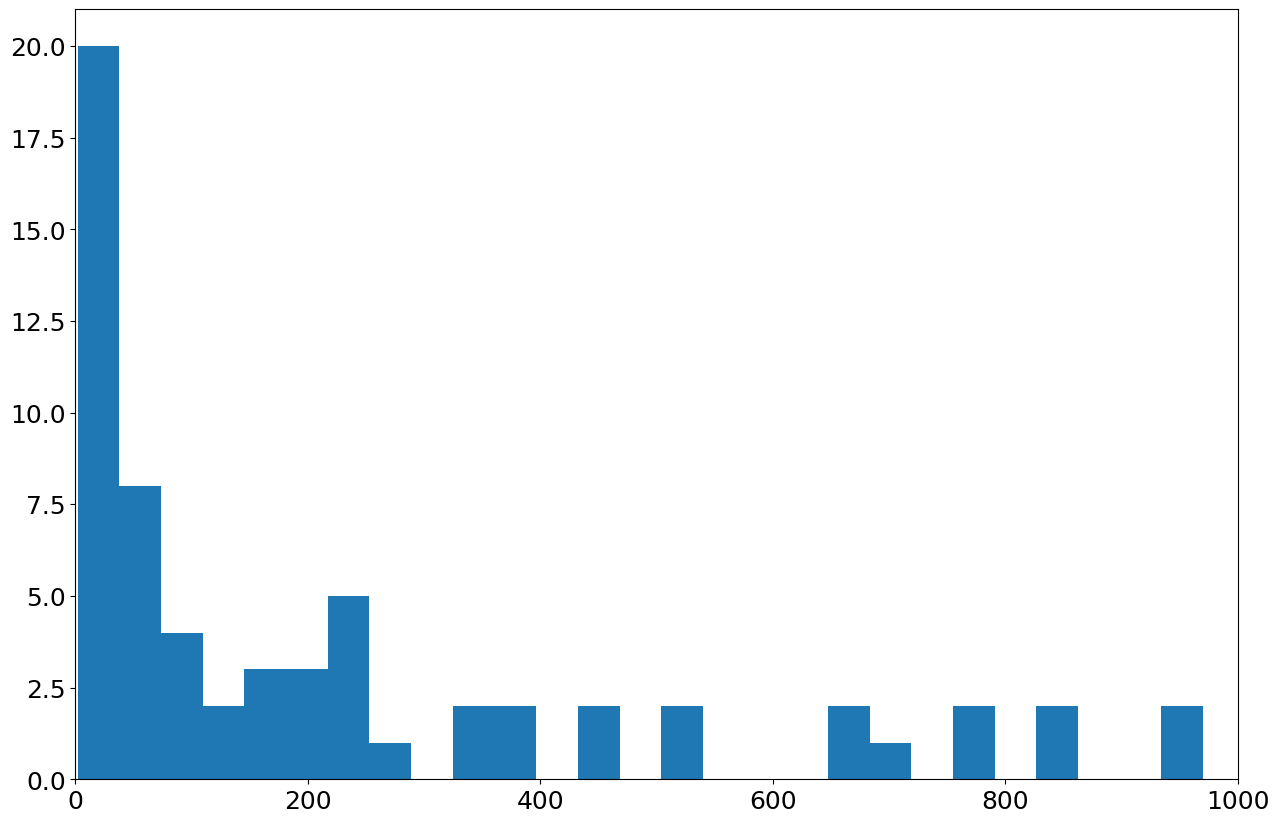

In [74]:
plt.hist(own_K, bins=1000)
plt.xlim(0, 1000)

Text(0, 0.5, 'Estimated K (m2/s)')

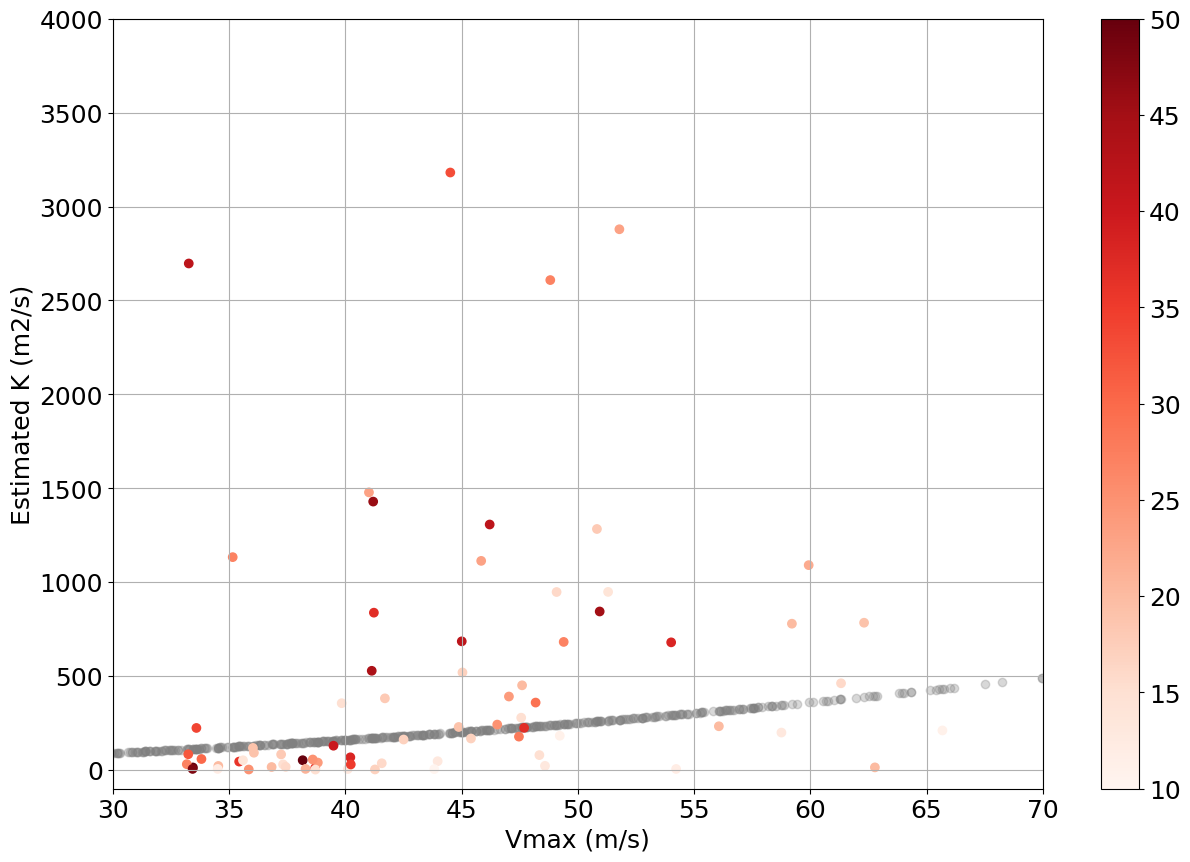

In [76]:
plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
plt.scatter(dsm.vmx, own_K, c=dsm.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
plt.ylim(-100, 4000)
plt.xlim(30, 70)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Estimated K (m2/s)')

In [33]:
dsm.where(own_K > 10000, drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 8)> Size: 64B
array(['s1a-ew-owi-ca-20181007t023405-20181007t023610-000003-029FF5_sw_ep212018_cyclone_polar.nc',
       's1a-ew-owi-ca-20191008t203040-20191008t203250-000003-0356ED_sw_wp202019_cyclone_polar.nc',
       's1b-ew-owi-ca-20210907t214630-20210907t215005-000003-0369AB_sw_al122021_cyclone_polar.nc',
       's1a-ew-owi-ca-20230908t092521-20230908t092624-000003-060BF1_sw_al132023_cyclone_polar.nc',
       'rcm1-sclnc-owi-ca-20230912t101305-20230912t101421-00003-______sw_al132023_cyclone_polar.nc',
       'rcm2-sclnd-owi-ca-20231012t200843-20231012t201000-00003-______sw_wp152023_cyclone_polar.nc',
       'rcm2-sc50mc-owi-ca-20231019t130413-20231019t130530-00003-______sw_ep172023_cyclone_polar.nc',
       'rcm2-sc50mc-owi-ca-20240905t103247-20240905t103359-00003-______sw_wp122024_cyclone_polar.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 64B 2018-10-07T02:35:07 ... 2024-09-05T10:...
Attributes:
    long_name:    File name in the TCVA database
    description:  Taken from Ifremer TCVA product

In [34]:
dsm.where(own_K > 10000, drop=True).max_asym_sar

<xarray.DataArray 'max_asym_sar' (time: 8)> Size: 64B
array([3.84383733, 2.37553657, 4.4756809 , 7.06944226, 3.59590783,
       8.6839723 , 5.52656552, 7.31371192])
Coordinates:
  * time     (time) datetime64[ns] 64B 2018-10-07T02:35:07 ... 2024-09-05T10:...

In [35]:
dsm.where(own_K > 10000, drop=True).cd_mean3 * 1e3

<xarray.DataArray 'cd_mean3' (time: 8)> Size: 64B
array([2.54703535, 3.20985728, 3.08514761, 2.28461629, 3.23070695,
       3.5733827 , 2.41319865, 2.74486127])
Coordinates:
  * time     (time) datetime64[ns] 64B 2018-10-07T02:35:07 ... 2024-09-05T10:...

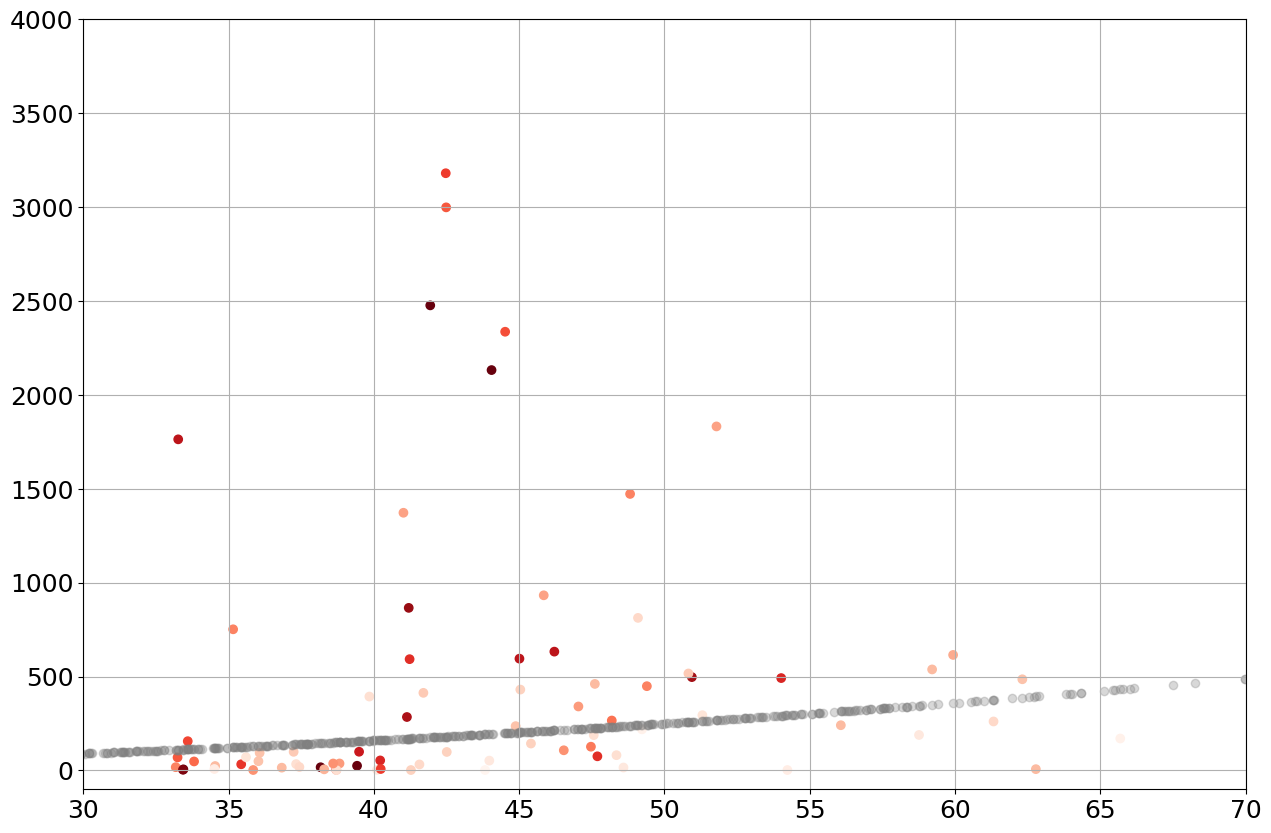

In [36]:
plt.scatter(dsm.vmx, own_K2, c=dsm.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
plt.ylim(-100, 4000)
plt.xlim(30, 70)
plt.grid()

### Grouping cases that have a similar Vmax, B, and Rmax

In [37]:
dkk = dk.where(
    (dk.vmx >= 40) & (dk.vmx <= 50) & (dk.B_hol >= 1.5) & (dk.B_hol <= 2) & (dk. rmx <= 30000)
)

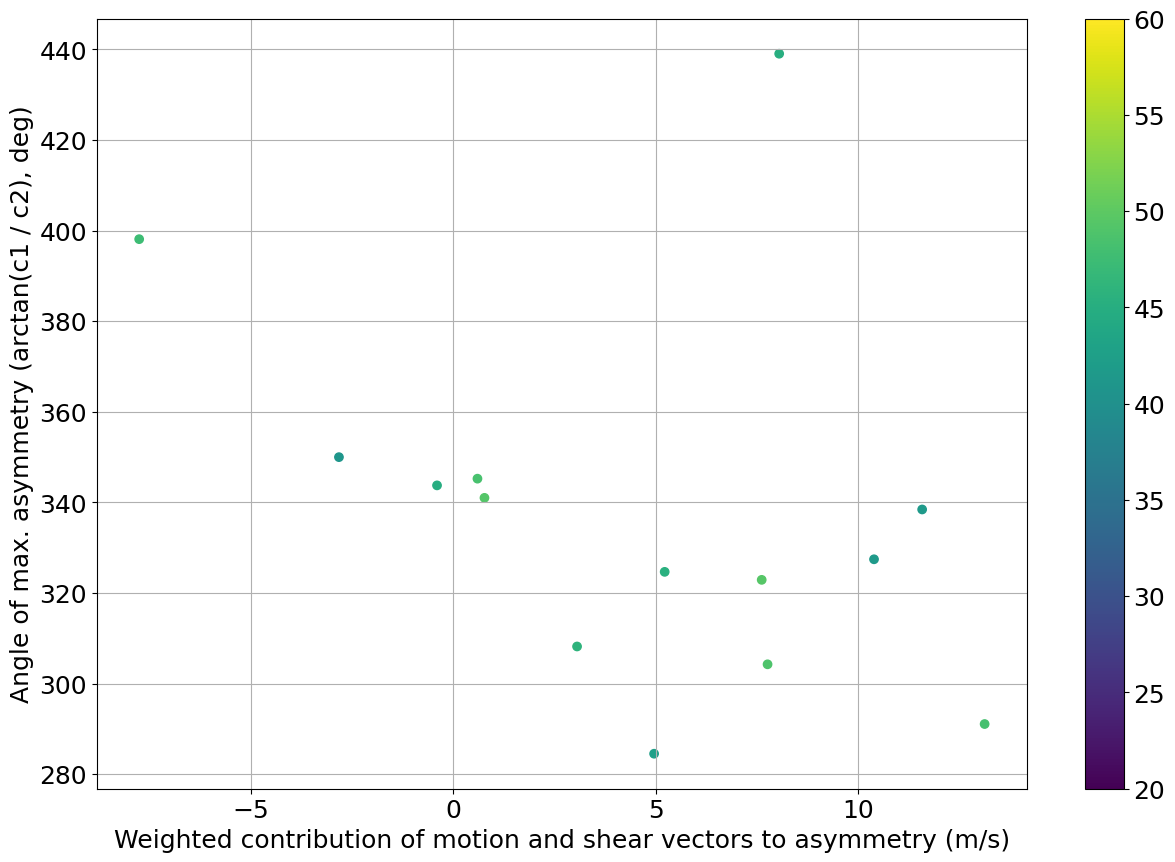

In [38]:
# c1 / c2 as a function of relative contribution from shear and motion vectors
# NB: les outliers en haut semblent normaux
# NB: l'outlier tout à gauche à un Vmax très faible, proche de 20 m/s
plt.scatter(dkk.storm_speed_ibt * np.cos(np.deg2rad(dkk.storm_dir_ibt)) + dkk.vws_pmd * np.cos(np.deg2rad(dkk.wsd_pmd)), angles_bis, c=dkk.vmx, vmin=20, vmax=60)
plt.colorbar()
plt.xlabel('Weighted contribution of motion and shear vectors to asymmetry (m/s)')
plt.ylabel('Angle of max. asymmetry (arctan(c1 / c2), deg)')
plt.grid()

### Estimating (C /sqrt(K), c1, c2) from (Ut, VWS, Holland params)

CAVEAT: I need to consider the cosinus/sinus of the angles.

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [40]:
dk['cos_mtnd'] = np.cos(np.deg2rad(dk.storm_dir_ibt))
dk['sin_mtnd'] = np.sin(np.deg2rad(dk.storm_dir_ibt))
dk['cos_vwsd'] = np.cos(np.deg2rad(dk.wsd_pmd))
dk['sin_vwsd'] = np.sin(np.deg2rad(dk.wsd_pmd))

In [41]:
preds   = ['storm_speed_ibt', 'cos_mtnd', 'sin_mtnd', 'cos_vwsd', 'sin_vwsd', 'vmx', 'rmx', 'B_hol', 'fcor']
targets = ['C_sqrtK_K25', 'c1_K25', 'c2_K25']
dk_reg  = dk[preds + targets].dropna(dim='time', how='any')
dk_df   = dk_reg.to_dataframe()
dk_df['C_sqrtK_K25'] = dk_df['C_sqrtK_K25'] * 1e5

In [42]:
X = dk_df[preds]
y = dk_df[targets]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Taille de l'ensemble d'entraînement (X_train): {X_train.shape}")
print(f"Taille de l'ensemble de test (X_test): {X_test.shape}")
print(f"Taille de l'ensemble d'entraînement (y_train): {y_train.shape}")
print(f"Taille de l'ensemble de test (y_test): {y_test.shape}")

# Initialiser le modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

Taille de l'ensemble d'entraînement (X_train): (69, 9)
Taille de l'ensemble de test (X_test): (18, 9)
Taille de l'ensemble d'entraînement (y_train): (69, 3)
Taille de l'ensemble de test (y_test): (18, 3)


In [44]:
# Puisqu'il s'agit d'une multi-régression (plusieurs variables cibles),
# les métriques seront calculées pour chaque variable cible.

# Coefficients du modèle
print("\nCoefficients du modèle pour chaque variable cible:")
for i, target_name in enumerate(targets):
    print(f"  Pour '{target_name}':")
    for feature, coef in zip(preds, model.coef_[i]):
        print(f"    {feature}: {coef:.4f}")
    print(f"  Intercept (ordonnée à l'origine) pour '{target_name}': {model.intercept_[i]:.4f}")
    print("-" * 30)

# Métriques d'évaluation
print("\nMétriques d'évaluation (RMSE et R-squared) pour chaque variable cible:")
for i, target_name in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(y_test[target_name], y_pred[:, i]))
    r2 = r2_score(y_test[target_name], y_pred[:, i])
    print(f"  Pour '{target_name}':")
    print(f"    Erreur Quadratique Moyenne (RMSE): {rmse:.4f}")
    print(f"    Coefficient de Détermination (R-squared): {r2:.4f}")
    print("-" * 30)

# Si vous voulez voir un aperçu des prédictions vs. les vraies valeurs
print("\nQuelques exemples de prédictions vs. vraies valeurs (pour les 5 premières entrées de l'ensemble de test):")
for i in range(min(5, len(y_test))):
    print(f"\nExemple {i+1}:")
    for j, target_name in enumerate(targets):
        print(f"  {target_name}: Vrai = {y_test.iloc[i][target_name]:.4f}, Prédit = {y_pred[i, j]:.4f}")



Coefficients du modèle pour chaque variable cible:
  Pour 'C_sqrtK_K25':
    storm_speed_ibt: -0.5004
    cos_mtnd: -4.7315
    sin_mtnd: -9.1132
    cos_vwsd: -12.2851
    sin_vwsd: 2.9954
    vmx: -1.6330
    rmx: -0.0002
    B_hol: -24.8697
    fcor: 440932.3963
  Intercept (ordonnée à l'origine) pour 'C_sqrtK_K25': 125.6156
------------------------------
  Pour 'c1_K25':
    storm_speed_ibt: -0.0013
    cos_mtnd: -0.2193
    sin_mtnd: 0.4288
    cos_vwsd: -0.3925
    sin_vwsd: -0.0420
    vmx: -0.0192
    rmx: -0.0000
    B_hol: -0.1570
    fcor: -9646.7086
  Intercept (ordonnée à l'origine) pour 'c1_K25': 1.5607
------------------------------
  Pour 'c2_K25':
    storm_speed_ibt: 0.1755
    cos_mtnd: -0.5786
    sin_mtnd: -0.0908
    cos_vwsd: -0.1765
    sin_vwsd: 0.0489
    vmx: 0.0278
    rmx: 0.0000
    B_hol: -0.2476
    fcor: 13473.2911
  Intercept (ordonnée à l'origine) pour 'c2_K25': -1.2778
------------------------------

Métriques d'évaluation (RMSE et R-squared) pour c

### Fitting sets comparisons

In [45]:
model_dir = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/'
ds1       = xr.open_dataset(model_dir + 'dsg_K25_withKsetto1.nc')
ds50      = xr.open_dataset(model_dir + 'dsg_K25_withKsetto50.nc')
ds200     = xr.open_dataset(model_dir + 'dsg_K25_withKsetto200.nc')

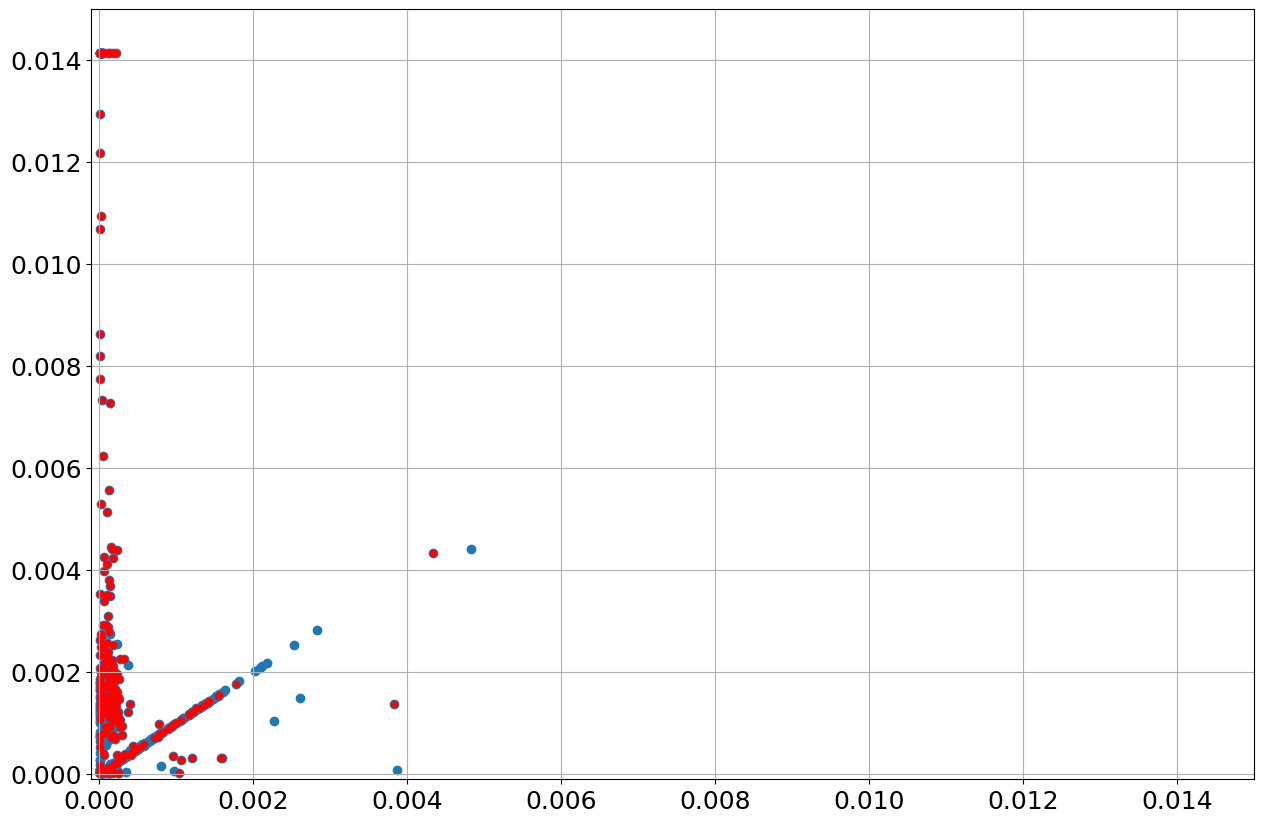

In [46]:
ftr = (
    (ds1.max_asym_sar <= 3) |
    (ds1.max_asym_K25 <= 2) |
    # ds1.phase_avg_err >= 90
    (ds1.non_C1.astype(np.bool))
)

plt.scatter(ds50.C_sqrtK_K25, ds1.C_sqrtK_K25)
plt.scatter(ds50.C_sqrtK_K25.where(ftr), ds1.C_sqrtK_K25.where(ftr), c='r', s=20)
plt.xlim(-0.0001, 0.015)
plt.ylim(-0.0001, 0.015)
plt.grid()

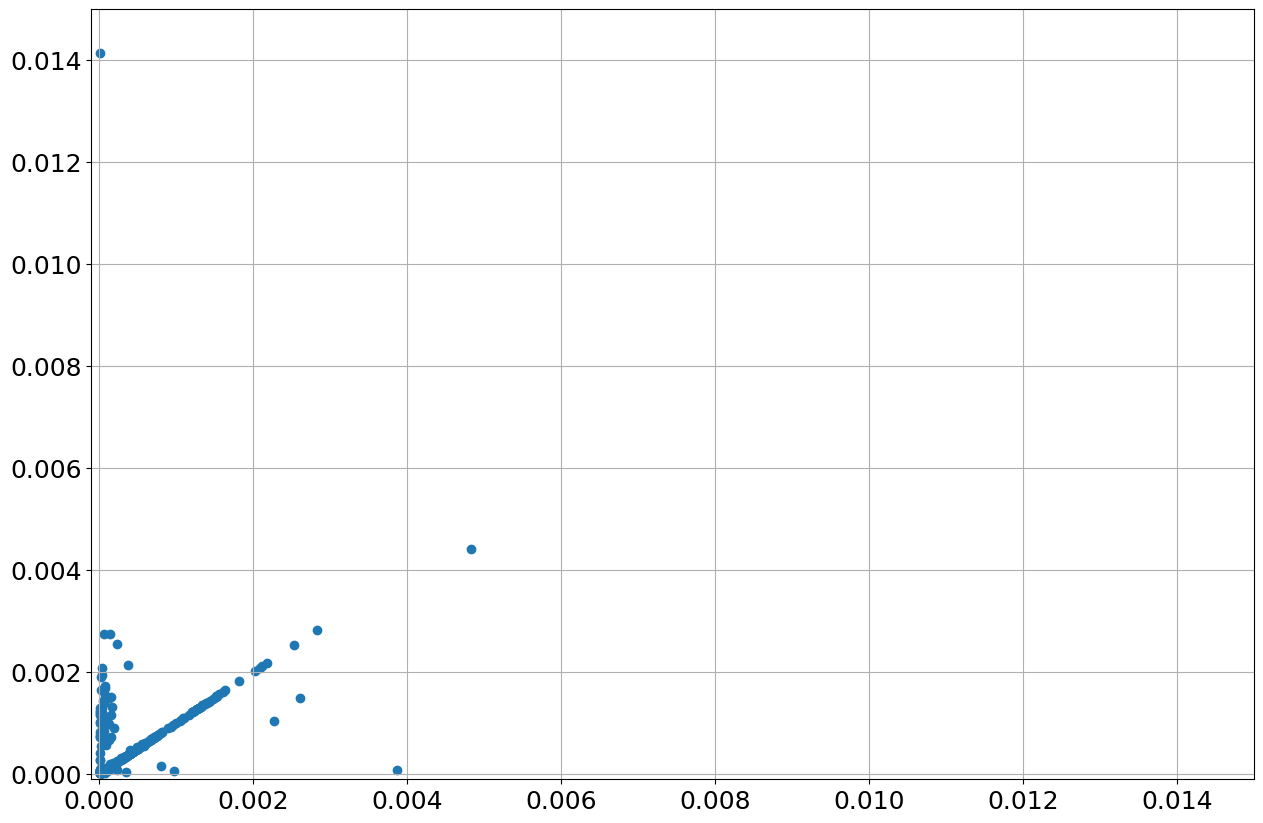

In [47]:
plt.scatter(ds50.where(~ftr, drop=True).C_sqrtK_K25, ds1.where(~ftr, drop=True).C_sqrtK_K25)
plt.xlim(-0.0001, 0.015)
plt.ylim(-0.0001, 0.015)
plt.grid()

(0.0, 0.003)

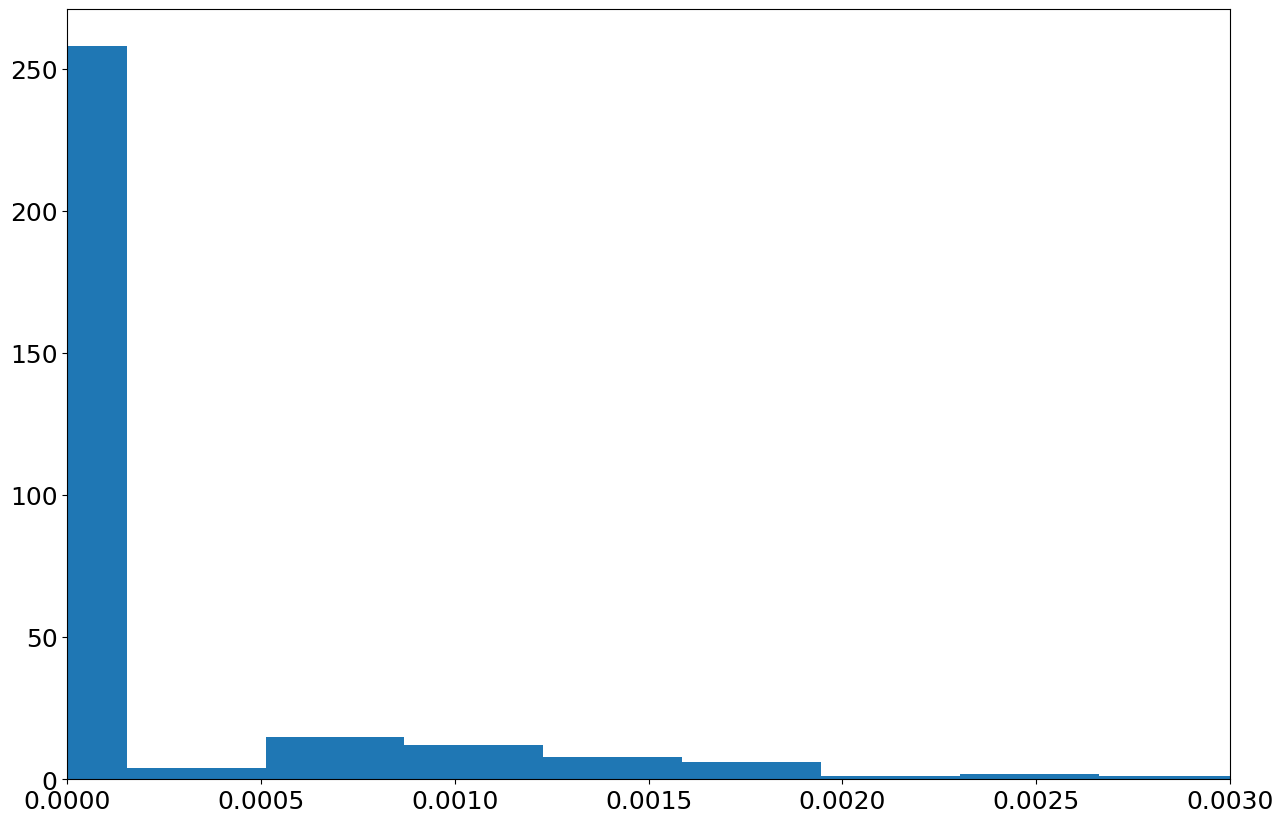

In [48]:
plt.hist((ds1.where(~ftr, drop=True).C_sqrtK_K25 - ds50.where(~ftr, drop=True).C_sqrtK_K25), bins=50)
plt.xlim(0, 0.003)

In [49]:
ds1.where(~ftr, drop=True).where((ds1.where(~ftr, drop=True).C_sqrtK_K25 - ds50.where(~ftr, drop=True).C_sqrtK_K25) > 0.0005, drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 46)> Size: 368B
array(['rs2--owi-ca-20140717t102721-20140717t102909-00003-______sw_wp092014_cyclone_polar.nc',
       'rs2--owi-ca-20140907t014846-20140907t015037-00003-______sw_ep142014_cyclone_polar.nc',
       'rs2--owi-ca-20141101t205327-20141101t205443-00003-______sw_wp202014_cyclone_polar.nc',
       'rs2--owi-ca-20150903t152310-20150903t152714-00003-______sw_ep132015_cyclone_polar.nc',
       'rs2--owi-ca-20151023t124550-20151023t124825-00003-______sw_ep202015_cyclone_polar.nc',
       's1a-iw-owi-ca-20170907t102951-20170907t103127-000003-01EB76_sw_al112017_cyclone_polar.nc',
       'rs2--owi-ca-20180724t205425-20180724t205648-00003-______sw_wp152018_cyclone_polar.nc',
       's1a-ew-owi-ca-20180831t203802-20180831t204009-000003-028EDA_sw_wp252018_cyclone_polar.nc',
       's1a-ew-owi-ca-20181010t114907-20181010t115212-000003-02A192_sw_al142018_cyclone_polar.nc',
       's1b-ew-owi-ca-20190503t001255-20190503t001459-000003-01E3AE_sw_io012019_cyclone_polar.nc',
       's1b-ew-owi-ca-20190906t141103-20190906t141249-000003-021B95_sw_ep112019_cyclone_polar.nc',
       'rs2--owi-ca-20191007t202139-20191007t202254-00003-______sw_wp202019_cyclone_polar.nc',
       'rs2--owi-ca-20200902t084047-20200902t084419-00003-______sw_wp112020_cyclone_polar.nc',
       'rs2--owi-ca-20201002t022254-20201002t022409-00003-______sw_ep182020_cyclone_polar.nc',
       's1b-ew-owi-ca-20201004t142803-20201004t143007-000003-02CF68_sw_ep182020_cyclone_polar.nc',
       's1a-ew-owi-ca-20201026t221102-20201026t221307-000003-041438_sw_wp212020_cyclone_polar.nc',
       's1a-ew-owi-ca-20210118t144525-20210118t144726-000003-043E8B_sw_sh122021_cyclone_polar.nc',
       's1b-iw-owi-ca-20210220t030122-20210220t030237-000003-030FCF_sw_sh212021_cyclone_polar.nc',
       'rcm1-sc50md-owi-ca-20210417t211214-20210417t211638-00003-______sw_wp022021_cyclone_polar.nc',
       'rs2--owi-ca-20220326t004133-20220326t004249-00003-______sw_sh222022_cyclone_polar.nc',
...
       'rcm1-sclnb-owi-ca-20230909t220434-20230909t220551-00003-______sw_al132023_cyclone_polar.nc',
       'rcm1-sclnb-owi-ca-20230910t221257-20230910t221412-00003-______sw_al132023_cyclone_polar.nc',
       'rcm1-sclnb-owi-ca-20230911t222124-20230911t222239-00003-______sw_al132023_cyclone_polar.nc',
       'rcm3-sc50mb-owi-ca-20231002t093638-20231002t093753-00003-______sw_wp142023_cyclone_polar.nc',
       'rcm2-sclnd-owi-ca-20231012t200843-20231012t201000-00003-______sw_wp152023_cyclone_polar.nc',
       'rcm2-sc50ma-owi-ca-20231021t131844-20231021t132000-00003-______sw_ep172023_cyclone_polar.nc',
       'rcm1-sc50ma-owi-ca-20231114t063722-20231114t063839-00003-______sw_sh022024_cyclone_polar.nc',
       'rcm1-sc50ma-owi-ca-20240529t090534-20240529t090650-00003-______sw_wp012024_cyclone_polar.nc',
       'rcm2-sc50ma-owi-ca-20240702t224344-20240702t224458-00003-______sw_al022024_cyclone_polar.nc',
       'rcm2-sc50mc-owi-ca-20240826t091441-20240826t091559-00003-______sw_wp112024_cyclone_polar.nc',
       's1a-ew-owi-ca-20240904t221810-20240904t221913-000003-06C64F_sw_wp122024_cyclone_polar.nc',
       'rcm2-sc50mc-owi-ca-20240905t103247-20240905t103359-00003-______sw_wp122024_cyclone_polar.nc',
       'rcm2-sc50ma-owi-ca-20240905t222628-20240905t222744-00003-______sw_wp122024_cyclone_polar.nc',
       'rcm1-sclnd-owi-ca-20241009t112521-20241009t112639-00003-______sw_al142024_cyclone_polar.nc',
       'rcm2-sc50ma-owi-ca-20241210t013942-20241210t014057-00003-______sw_sh042025_cyclone_polar.nc',
       'rcm1-sclna-owi-ca-20250112t152109-20250112t152224-00003-______sw_sh072025_cyclone_polar.nc',
       'rcm1-sclna-owi-ca-20250119t220506-20250119t220620-00003-______sw_sh102025_cyclone_polar.nc',
       'rcm3-sclnc-owi-ca-20250202t103947-20250202t104104-00003-______sw_sh142025_cyclone_polar.nc',
       'rcm1-sclna-owi-ca-20250302t152524-20250302t152641-00003-______sw_sh232025_cyclone_polar.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 368B 

In [50]:
ds50.where(~ftr, drop=True)

<xarray.Dataset> Size: 217kB
Dimensions:              (time: 319)
Coordinates:
  * time                 (time) datetime64[ns] 3kB 2013-07-01T10:41:57 ... 20...
Data variables: (12/84)
    dist2coast           (time) float64 3kB 8.115e+04 5.784e+04 ... 4.137e+05
    speed                (time) float64 3kB 5.97 6.893 5.511 ... 2.479 2.946
    name                 (time) object 3kB 'RUMBIA' 'JEBI' ... 'HONDE' 'HONDE'
    id                   (time) object 3kB 'wp062013' 'wp092013' ... 'sh232025'
    file                 (time) object 3kB 'rs2--owi-cm-20130701t104119-20130...
    file_tcva            (time) object 3kB 'rs2--owi-ca-20130701t104119-20130...
    ...                   ...
    non_C1               (time) float64 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    max_asym_sar         (time) float64 3kB 4.822 4.053 4.879 ... 4.885 nan nan
    max_asym_K25         (time) float64 3kB 4.679 3.139 3.679 ... 3.556 4.478
    asym_avg_err         (time) float64 3kB 2.159 0.8055 0.6508 ... nan nan
    phase_avg_err        (time) float64 3kB 14.82 19.7 30.86 ... 25.51 nan nan
    C_K25                (time) float64 3kB 0.001075 0.0001 ... 0.0001065
Attributes:
    Version:            1.0
    SAR_wind_product:   Ifremer (https://cyclobs.ifremer.fr/app/tropical), co...
    Best_track_data:    IBTrACS (https://www.ncei.noaa.gov/products/internati...
    SST_product:        REMSS, collocated with tropical cyclones during MAXSS...
    Authors:            Arthur Avenas, Alexis Mouche, Théo Cevaer
    Contact:            arthur.avenas@esa.int
    TC-PRIMED_product:  Version v01r01-preliminary, created 2024-11-20T06:17:...
    fixed_K:            50

In [51]:
ds1.where(~ftr, drop=True)

<xarray.Dataset> Size: 217kB
Dimensions:              (time: 319)
Coordinates:
  * time                 (time) datetime64[ns] 3kB 2013-07-01T10:41:57 ... 20...
Data variables: (12/84)
    dist2coast           (time) float64 3kB 8.115e+04 5.784e+04 ... 4.137e+05
    speed                (time) float64 3kB 5.97 6.893 5.511 ... 2.479 2.946
    name                 (time) object 3kB 'RUMBIA' 'JEBI' ... 'HONDE' 'HONDE'
    id                   (time) object 3kB 'wp062013' 'wp092013' ... 'sh232025'
    file                 (time) object 3kB 'rs2--owi-cm-20130701t104119-20130...
    file_tcva            (time) object 3kB 'rs2--owi-ca-20130701t104119-20130...
    ...                   ...
    non_C1               (time) float64 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    max_asym_sar         (time) float64 3kB 4.822 4.053 4.879 ... 4.885 nan nan
    max_asym_K25         (time) float64 3kB 4.679 3.158 3.389 ... 3.45 4.604
    asym_avg_err         (time) float64 3kB 2.16 0.7946 0.7996 ... 1.447 nan nan
    phase_avg_err        (time) float64 3kB 14.82 16.79 28.59 ... 30.65 nan nan
    C_K25                (time) float64 3kB 0.0001519 1.414e-05 ... 1.753e-05
Attributes:
    Version:            1.0
    SAR_wind_product:   Ifremer (https://cyclobs.ifremer.fr/app/tropical), co...
    Best_track_data:    IBTrACS (https://www.ncei.noaa.gov/products/internati...
    SST_product:        REMSS, collocated with tropical cyclones during MAXSS...
    Authors:            Arthur Avenas, Alexis Mouche, Théo Cevaer
    Contact:            arthur.avenas@esa.int
    TC-PRIMED_product:  Version v01r01-preliminary, created 2024-11-20T06:17:...
    fixed_K:            1

In [52]:
### Errors: Non-C1 cases, or cases that have "flat" asymmetries (w.r.t their Vmax)
# For instance because  of low Vmax and/or low V_trans
# Many of these cases also have their K25 asymmetries constant and equal to 1

In [53]:
# ds1.where((ds1.C_sqrtK_K25 - ds50.C_sqrtK_K25) > 0.005, drop=True).isel(time=8)

In [54]:
# (ds1.C_sqrtK_K25 - ds50.C_sqrtK_K25) > 0.005

In [55]:
ds1.where((ds1.C_sqrtK_K25 - ds50.C_sqrtK_K25) > 0.005, drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 36)> Size: 288B
array(['rs2--owi-ca-20140717t225349-20140717t225504-00003-______sw_wp092014_cyclone_polar.nc',
       'rs2--owi-ca-20141003t131421-20141003t131537-00003-______sw_ep192014_cyclone_polar.nc',
       'rs2--owi-ca-20150601t015945-20150601t020101-00003-______sw_ep012015_cyclone_polar.nc',
       'rs2--owi-ca-20161006t223232-20161006t223348-00003-______sw_al152016_cyclone_polar.nc',
       's1a-iw-owi-ca-20170504t071401-20170504t071505-000003-01B35C_sw_sh182017_cyclone_polar.nc',
       's1a-ew-owi-ca-20181110t020115-20181110t020319-000003-02B0A7_sw_sh032019_cyclone_polar.nc',
       's1a-ew-owi-ca-20190311t024310-20190311t024514-000003-02F003_sw_sh182019_cyclone_polar.nc',
       's1a-ew-owi-ca-20190427t123324-20190427t123528-000003-03095B_sw_sh252019_cyclone_polar.nc',
       's1b-ew-owi-ca-20190612t011725-20190612t011929-000003-01F595_sw_io022019_cyclone_polar.nc',
       's1a-ew-owi-ca-20191008t203040-20191008t203250-000003-0356ED_sw_wp202019_cyclone_polar.nc',
       'rs2--owi-ca-20210208t235939-20210209t000055-00003-______sw_sh192021_cyclone_polar.nc',
       'rs2--owi-ca-20210307t130816-20210307t130931-00003-______sw_sh242021_cyclone_polar.nc',
       'rcm1-sc50md-owi-ca-20210418t211549-20210418t212533-00003-______sw_wp022021_cyclone_polar.nc',
       's1a-iw-owi-ca-20210418t212223-20210418t212342-000003-046C42_sw_wp022021_cyclone_polar.nc',
       'rcm2-sc50md-owi-ca-20210422t211644-20210422t212548-00003-______sw_wp022021_cyclone_polar.nc',
       'rs2--owi-ca-20220129t134018-20220129t134242-00003-______sw_sh082022_cyclone_polar.nc',
       'rs2--owi-ca-20220927t232735-20220927t232958-00003-______sw_al092022_cyclone_polar.nc',
       'rcm3-sclnd-owi-ca-20221223t235601-20221223t235719-00003-______sw_sh052023_cyclone_polar.nc',
       's1a-ew-owi-ca-20230125t024334-20230125t024630-000003-05A0FA_sw_sh082023_cyclone_polar.nc',
       'rcm1-sclnd-owi-ca-20230209t111056-20230209t111212-00003-______sw_sh112023_cyclone_polar.nc',
       'rcm1-sclna-owi-ca-20230330t111910-20230330t112038-00003-______sw_sh172023_cyclone_polar.nc',
       'rcm3-sclnc-owi-ca-20230330t222809-20230330t222926-00003-______sw_sh172023_cyclone_polar.nc',
       'rcm2-sclna-owi-ca-20230513t235455-20230513t235607-00003-______sw_io012023_cyclone_polar.nc',
       's1a-ew-owi-ca-20230802t094501-20230802t094605-000003-05F9CD_sw_wp062023_cyclone_polar.nc',
       'rcm3-sc50ma-owi-ca-20230828t094404-20230828t094519-00003-______sw_wp092023_cyclone_polar.nc',
       'rcm1-sc50ma-owi-ca-20231024t070211-20231024t070327-00003-______sw_sh012024_cyclone_polar.nc',
       'rcm1-sclna-owi-ca-20231024t120111-20231024t120227-00003-______sw_io062023_cyclone_polar.nc',
       'rcm3-sc50ma-owi-ca-20231114t174732-20231114t174847-00003-______sw_sh022024_cyclone_polar.nc',
       'rcm3-sclna-owi-ca-20240120t233138-20240120t233253-00003-______sw_sh062024_cyclone_polar.nc',
       'rcm2-sc50ma-owi-ca-20240702t224344-20240702t224458-00003-______sw_al022024_cyclone_polar.nc',
       'rcm2-sclnc-owi-ca-20240821t140027-20240821t140143-00003-______sw_ep072024_cyclone_polar.nc',
       'rcm2-sclnd-owi-ca-20240822t140821-20240822t140937-00003-______sw_ep072024_cyclone_polar.nc',
       'rcm2-sc50mc-owi-ca-20240827t211136-20240827t211254-00003-______sw_wp112024_cyclone_polar.nc',
       'rcm1-sclnd-owi-ca-20240926t010030-20240926t010148-00003-______sw_ep102024_cyclone_polar.nc',
       'rcm2-sc50ma-owi-ca-20241211t014747-20241211t014903-00003-______sw_sh042025_cyclone_polar.nc',
       'rcm3-sclnd-owi-ca-20250228t154212-20250228t154328-00003-______sw_sh232025_cyclone_polar.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 288B 2014-07-17T22:54:26 ... 2025-02-28T15...
Attributes:
    long_name:    File name in the TCVA database
    description:  Taken from Ifremer TCVA product

In [56]:
ds1.where((ds1.C_sqrtK_K25 == ds50.C_sqrtK_K25), drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 33)> Size: 264B
array(['rs2--owi-ca-20130802t223244-20130802t223400-00003-______sw_wp092013_cyclone_polar.nc',
       'rs2--owi-ca-20150803t202943-20150803t203347-00003-______sw_wp132015_cyclone_polar.nc',
       'rs2--owi-ca-20150906t185705-20150906t185821-00003-______sw_cp032015_cyclone_polar.nc',
       's1b-iw-owi-ca-20170923t104349-20170923t104554-000003-00D45F_sw_al152017_cyclone_polar.nc',
       's1a-ew-owi-ca-20180914t095035-20180914t095221-000003-029526_sw_wp262018_cyclone_polar.nc',
       's1a-ew-owi-ca-20180929t020104-20180929t020308-000003-029C16_sw_ep202018_cyclone_polar.nc',
       's1a-ew-owi-ca-20181009t234305-20181009t234610-000003-02A153_sw_al142018_cyclone_polar.nc',
       's1a-ew-owi-ca-20190214t182852-20190214t183056-000003-02E348_sw_sh152019_cyclone_polar.nc',
       's1b-ew-owi-ca-20190218t184446-20190218t184711-000003-01C08C_sw_sh152019_cyclone_polar.nc',
       's1a-ew-owi-ca-20190322t214643-20190322t214850-000003-02F65C_sw_sh212019_cyclone_polar.nc',
       'rs2--owi-ca-20210905t213342-20210905t213606-00003-______sw_al122021_cyclone_polar.nc',
       's1b-ew-owi-ca-20210908t091631-20210908t091835-000003-0369DA_sw_wp192021_cyclone_polar.nc',
       's1b-ew-owi-ca-20210926t090903-20210926t091107-000003-0371EC_sw_al182021_cyclone_polar.nc',
       'rcm2-sclnd-owi-ca-20230309t155937-20230309t160053-00003-______sw_sh112023_cyclone_polar.nc',
       'rcm3-sc50mc-owi-ca-20230716t221835-20230716t221951-00003-______sw_wp042023_cyclone_polar.nc',
       'rcm3-sc50mc-owi-ca-20230723t094306-20230723t094424-00003-______sw_wp052023_cyclone_polar.nc',
       'rcm3-sc50mc-owi-ca-20230724t095134-20230724t095251-00003-______sw_wp052023_cyclone_polar.nc',
       'rcm1-sc50mc-owi-ca-20230919t093118-20230919t093236-00003-______sw_al152023_cyclone_polar.nc',
       'rcm3-sc50mb-owi-ca-20231002t213003-20231002t213121-00003-______sw_wp142023_cyclone_polar.nc',
       's1a-ew-owi-ca-20231011t203059-20231011t203203-000003-061CAB_sw_wp152023_cyclone_polar.nc',
       's1a-ew-owi-ca-20240129t004139-20240129t004242-000003-065341_sw_sh062024_cyclone_polar.nc',
       'rcm1-sc50mb-owi-ca-20240721t094332-20240721t094449-00003-______sw_wp052024_cyclone_polar.nc',
       'rcm3-sc50mc-owi-ca-20240929t100030-20240929t100148-00003-______sw_wp202024_cyclone_polar.nc',
       'rcm2-sclnb-owi-ca-20241107t235027-20241107t235144-00003-______sw_al182024_cyclone_polar.nc',
       'rcm2-sc50mb-owi-ca-20241110t213918-20241110t214035-00003-______sw_wp262024_cyclone_polar.nc',
       'rcm1-sclnd-owi-ca-20241115t002735-20241115t002851-00003-______sw_sh022025_cyclone_polar.nc',
       'rcm2-sclnb-owi-ca-20241116t133638-20241116t133753-00003-______sw_sh022025_cyclone_polar.nc',
       'rcm1-sclnc-owi-ca-20241118t005253-20241118t005408-00003-______sw_sh022025_cyclone_polar.nc',
       'rcm2-sclna-owi-ca-20241119t135942-20241119t140059-00003-______sw_sh022025_cyclone_polar.nc',
       'rcm2-sclnd-owi-ca-20250203t215557-20250203t215713-00003-______sw_sh142025_cyclone_polar.nc',
       'rcm2-sclnd-owi-ca-20250204t234122-20250204t234237-00003-______sw_sh132025_cyclone_polar.nc',
       'rcm2-sclnb-owi-ca-20250210t121608-20250210t121722-00003-______sw_sh142025_cyclone_polar.nc',
       'rcm1-sclnd-owi-ca-20250303t020823-20250303t020937-00003-______sw_sh232025_cyclone_polar.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 264B 2013-08-02T22:33:22 ... 2025-03-03T02...
Attributes:
    long_name:    File name in the TCVA database
    description:  Taken from Ifremer TCVA product

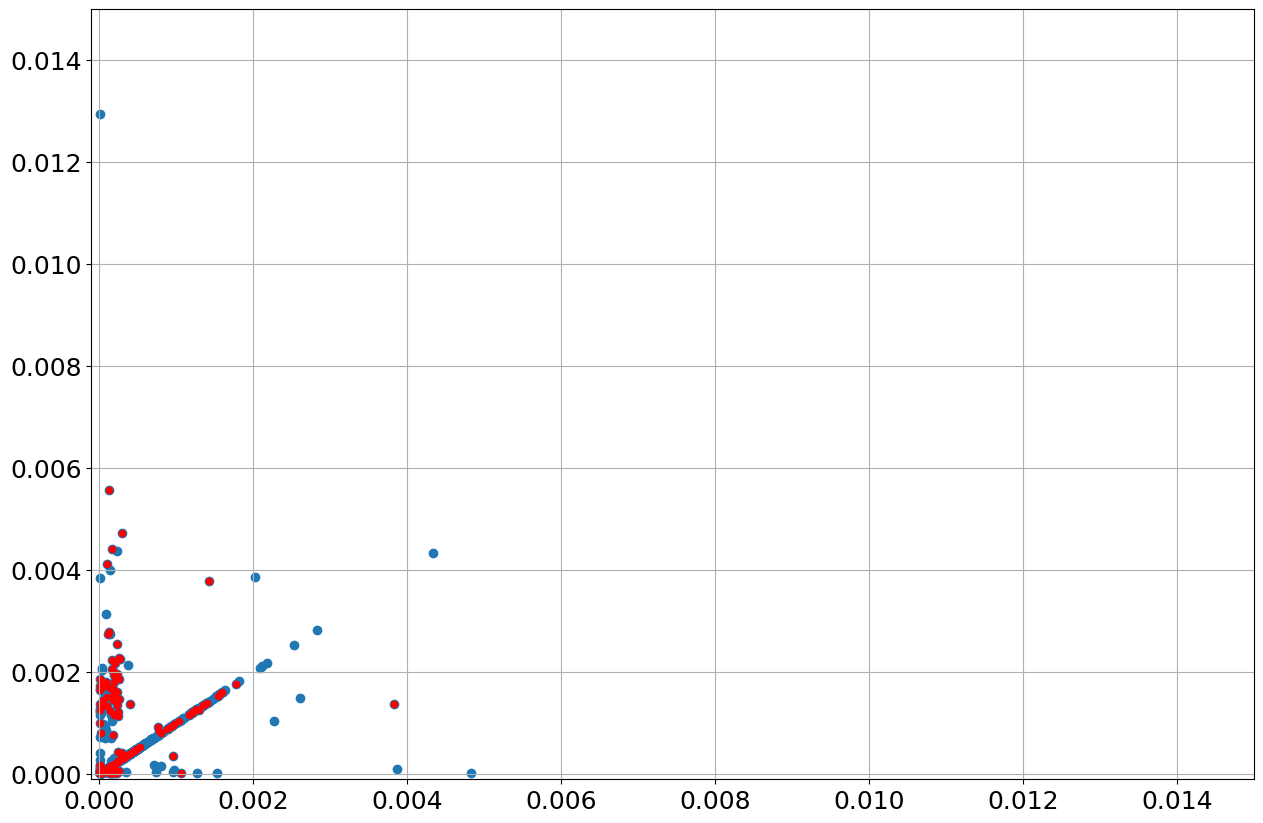

In [57]:
plt.scatter(ds50.C_sqrtK_K25, ds200.C_sqrtK_K25)
plt.scatter(ds50.C_sqrtK_K25.where(ds200.non_C1), ds200.C_sqrtK_K25.where(ds200.non_C1), c='r', s=20)
plt.xlim(-0.0001, 0.015)
plt.ylim(-0.0001, 0.015)
plt.grid()

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   6.,   4.,   4., 349.,
         11.,  32.,  41.,  37.,  39.,  14.,   9.,   7.,   2.,   4.,   3.,
          4.,   0.,   1.,   2.,   0.,   1.,   0.,   0.,   2.,   0.,   1.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,  23.]),
 array([-0.00378816, -0.00342984, -0.00307152, -0.00271319, -0.00235487,
        -0.00199655, -0.00163822, -0.0012799 , -0.00092158, -0.00056325,
        -0.00020493,  0.00015339,  0.00051172,  0.00087004,  0.00122836,
         0.00158669,  0.00194501,  0.00230333,  0.00266165,  0.00301998,
         0.0033783 ,  0.00373662,  0.00409495,  0.00445327,  0.00481159,
         0.00516992,  0.00552824,  0.00588656,  0.00624489,  0.00660321,
         0.00696153,  0.00731985,  0.00767818,  0.0080365 ,  0.00839482,
         0.00875315,  0.00911147,  0.00946979,  0.00982812,  0.01018644,
         0.01054476,  0.01090309,  0.01126141,  0.01161973,  0.01197805,
 

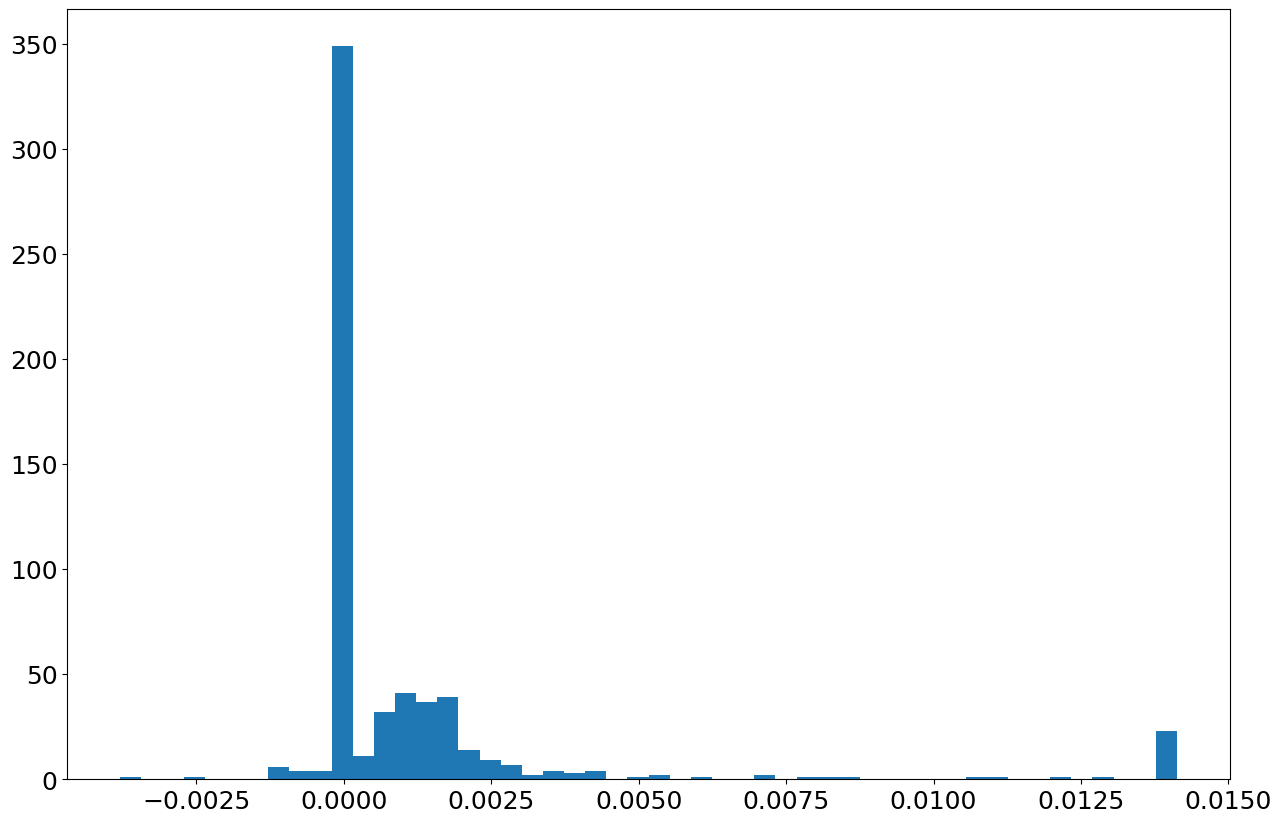

In [58]:
plt.hist(ds1.C_sqrtK_K25 - ds50.C_sqrtK_K25, bins=50)

In [59]:
# NIGEL
# rcm1-sc50mc-owi-ca-20230919t093118-20230919t093236-00003-______sw_al152023_cyclone_polar.nc
# Metop-C descending at 13:00
# (Also Metop-B)

In [60]:
test_file = 'rcm1-sclna-owi-ca-20230909t094956-20230909t095112-00003-______sw_al132023_cyclone_polar.nc'

In [61]:
ds1.where(ds1.file_tcva == test_file, drop=True).C_sqrtK_K25

<xarray.DataArray 'C_sqrtK_K25' (time: 1)> Size: 8B
array([0.00050277])
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-09-09T09:50:34

In [62]:
ds50.where(ds50.file_tcva == test_file, drop=True).C_sqrtK_K25

<xarray.DataArray 'C_sqrtK_K25' (time: 1)> Size: 8B
array([0.00050276])
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-09-09T09:50:34

In [63]:
ds50.where(ds50.file_tcva == test_file, drop=True).C_K25

<xarray.DataArray 'C_K25' (time: 1)> Size: 8B
array([0.00355506])
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-09-09T09:50:34

In [64]:
ds1.where(abs(ds1.C_sqrtK_K25 - ds50.C_sqrtK_K25) < 0.0000001, drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 220)> Size: 2kB
array(['rs2--owi-ca-20130701t104119-20130701t104235-00003-______sw_wp062013_cyclone_polar.nc',
       'rs2--owi-ca-20130802t223244-20130802t223400-00003-______sw_wp092013_cyclone_polar.nc',
       'rs2--owi-ca-20140805t093342-20140805t093535-00003-______sw_wp112014_cyclone_polar.nc',
       'rs2--owi-ca-20140807t155748-20140807t155950-00003-______sw_ep092014_cyclone_polar.nc',
       'rs2--owi-ca-20141102t011207-20141102t011322-00003-______sw_ep212014_cyclone_polar.nc',
       'rs2--owi-ca-20150514t195522-20150514t195638-00003-______sw_wp072015_cyclone_polar.nc',
       'rs2--owi-ca-20150715t144252-20150715t144408-00003-______sw_ep062015_cyclone_polar.nc',
       'rs2--owi-ca-20150803t202943-20150803t203347-00003-______sw_wp132015_cyclone_polar.nc',
       'rs2--owi-ca-20150805t211206-20150805t211322-00003-______sw_wp132015_cyclone_polar.nc',
       'rs2--owi-ca-20150830t154150-20150830t154305-00003-______sw_ep122015_cyclone_polar.nc',
       'rs2--owi-ca-20150902t201620-20150902t201736-00003-______sw_al062015_cyclone_polar.nc',
       'rs2--owi-ca-20150906t185705-20150906t185821-00003-______sw_cp032015_cyclone_polar.nc',
       'rs2--owi-ca-20160709t144141-20160709t144257-00003-______sw_ep032016_cyclone_polar.nc',
       's1a-ew-owi-ca-20160826t211505-20160826t211809-000003-01420D_sw_al072016_cyclone_polar.nc',
       'rs2--owi-ca-20160829t022730-20160829t023009-00003-______sw_ep132016_cyclone_polar.nc',
       's1a-iw-owi-ca-20160901t234439-20160901t234559-000003-01450E_sw_al092016_cyclone_polar.nc',
       's1a-iw-owi-ca-20160904t163028-20160904t163208-000003-014658_sw_ep132016_cyclone_polar.nc',
       'rs2--owi-ca-20160910t204800-20160910t204916-00003-______sw_wp162016_cyclone_polar.nc',
       'rs2--owi-ca-20160925t092440-20160925t092703-00003-______sw_wp202016_cyclone_polar.nc',
       'rs2--owi-ca-20161015t202838-20161015t202954-00003-______sw_wp252016_cyclone_polar.nc',
...
       'rcm2-sclna-owi-ca-20241119t135942-20241119t140059-00003-______sw_sh022025_cyclone_polar.nc',
       'rcm3-sclnd-owi-ca-20250112t022048-20250112t022204-00003-______sw_sh072025_cyclone_polar.nc',
       'rcm1-sclna-owi-ca-20250115t154228-20250115t154344-00003-______sw_sh072025_cyclone_polar.nc',
       'rcm1-sclnd-owi-ca-20250116t022411-20250116t022526-00003-______sw_sh072025_cyclone_polar.nc',
       's1a-ew-owi-ca-20250116t022957-20250116t023101-000003-071348_sw_sh072025_cyclone_polar.nc',
       'rcm2-sclnc-owi-ca-20250119t105402-20250119t105517-00003-______sw_sh102025_cyclone_polar.nc',
       'rcm1-sclnb-owi-ca-20250120t221352-20250120t221508-00003-______sw_sh102025_cyclone_polar.nc',
       's1a-ew-owi-ca-20250121t112606-20250121t112710-000003-07166F_sw_sh102025_cyclone_polar.nc',
       'rcm3-sclnd-owi-ca-20250203t122326-20250203t122443-00003-______sw_sh132025_cyclone_polar.nc',
       'rcm2-sclnd-owi-ca-20250203t215557-20250203t215713-00003-______sw_sh142025_cyclone_polar.nc',
       'rcm2-sclna-owi-ca-20250203t233252-20250203t233407-00003-______sw_sh132025_cyclone_polar.nc',
       'rcm3-sclna-owi-ca-20250204t123121-20250204t123237-00003-______sw_sh132025_cyclone_polar.nc',
       'rcm2-sclnd-owi-ca-20250204t234122-20250204t234237-00003-______sw_sh132025_cyclone_polar.nc',
       'rcm2-sclnb-owi-ca-20250210t121608-20250210t121722-00003-______sw_sh142025_cyclone_polar.nc',
       'rcm1-sclnc-owi-ca-20250210t232353-20250210t232507-00003-______sw_sh142025_cyclone_polar.nc',
       'rcm2-sclnd-owi-ca-20250211t212411-20250211t212528-00003-______sw_sh172025_cyclone_polar.nc',
       'rcm1-sclna-owi-ca-20250223t080636-20250223t080750-00003-______sw_sh182025_cyclone_polar.nc',
       'rcm1-sclna-owi-ca-20250301t015137-20250301t015252-00003-______sw_sh222025_cyclone_polar.nc',
       'rcm1-sclnd-owi-ca-20250303t020823-20250303t020937-00003-______sw_sh232025_cyclone_polar.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2013-07-01T10:41:57 ... 2025-03-03T02:...
A